In [4]:
import numpy as np
import open3d as o3d
from pyproj import Transformer
import pandas as pd
from scipy.spatial import ConvexHull
from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from tqdm import tqdm
import random
import warnings

# Import Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress pandas FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Optional: prettier fonts for publication-style visuals
rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# --- Coordinate transformation ---
def wgs_to_utm(df, lat_col='latitude', lon_col='longitude', alt_col='lidar(m)'):
    transformer = Transformer.from_crs("epsg:4326", "epsg:32633", always_xy=True)
    lon, lat, alt = df[lon_col].values, df[lat_col].values, df[alt_col].values
    x, y = transformer.transform(lon, lat)
    return np.stack([x, y, alt], axis=1).astype(np.float32)

# --- Detector position extraction ---
def extract_detector_positions(df):
    return wgs_to_utm(df, lat_col='latitude', lon_col='longitude', alt_col='height_wgs84(m)')

# --- Grid creation function (takes explicit bounds) ---
def create_reconstruction_grid_extent(min_x, max_x, min_y, max_y, voxel_size=4.0):
    grid_x = np.arange(min_x + voxel_size/2, max_x + voxel_size/2, voxel_size)
    grid_y = np.arange(min_y + voxel_size/2, max_y + voxel_size/2, voxel_size)
    bounds_dict = {"x": (min_x, max_x), "y": (min_y, max_y)}
    print(f"Created 2D grid extent: X={bounds_dict['x']}, Y={bounds_dict['y']}")
    return grid_x, grid_y, bounds_dict

# --- Kaczmarz Base and A-matrix construction functions ---
def _kaczmarz_base(detectors, grid_points, b, isotope):
    m, n = detectors.shape[0], grid_points.shape[0]
    x = np.zeros(n, dtype=np.float32)

    if isotope.lower() == "cs":
        emission_prob = 0.851
        mu_over_rho = 0.07925
    elif isotope.lower() == "co":
        emission_prob = 0.999
        mu_over_rho = 0.05270
    else:
        raise ValueError("Invalid isotope. Use 'cs' or 'co'.")

    rho_air = 0.001225
    mu_L = (mu_over_rho * rho_air) * 100
    return x, m, n, emission_prob, mu_L

def _get_A_matrix(detectors, grid_points, emission_prob, mu_L):
    dists = np.linalg.norm(detectors[:, None, :] - grid_points[None, :, :], axis=2) + 1e-6
    atten = np.exp(-mu_L * dists)
    A_matrix = emission_prob / (4 * np.pi * dists**2) * atten
    return A_matrix

# --- System Residual Calculation (for hyperparameter tuning) ---
def calculate_system_residual(x_recon, b, A_matrix):
    """
    Calculates the L2 norm of the full system residual.
    """
    predicted_b = A_matrix @ x_recon
    full_residual = b - predicted_b
    return np.linalg.norm(full_residual)


# --- MODIFIED: Plot 2D Reconstruction on Terrain Map (no thresholding) ---
def plot_2d_reconstruction_on_terrain_map(x_recon, xx_mesh, yy_mesh, Z_terrain, 
                                          grid_points_for_reconstruction, title="2D Reconstruction on Terrain"):
    """
    Plots the x_recon activity as a scatter plot overlaid on a 2D contour map of terrain elevation.
    **Applies non-negativity constraint for visualization.**
    """
    print(f"\nCreating 2D terrain map with reconstruction overlay for {title}...")

    x_recon_clamped = np.maximum(0, x_recon.copy()) 

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot terrain elevation using filled contours
    contour_levels = 50
    terrain_contour = ax.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)
    fig.colorbar(terrain_contour, ax=ax, label="Elevation (m)", pad=0.05)

    # Overlay reconstruction intensity as colored scatter points
    scatter_x = grid_points_for_reconstruction[:, 0]
    scatter_y = grid_points_for_reconstruction[:, 1]
    scatter_plot = ax.scatter(scatter_x, scatter_y, c=x_recon_clamped, cmap='hot', s=15, alpha=0.7, edgecolors='none')
    fig.colorbar(scatter_plot, ax=ax, label="Reconstructed Activity", pad=0.15)

    ax.set_xlabel("UTM Easting (m)")
    ax.set_ylabel("UTM Northing (m)")
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    # Also print top 10 intensities
    x_vec_flat = x_recon_clamped.flatten()
    flat_indices = np.argsort(x_vec_flat)[::-1]

    print(f"\n Top 10 Intensities for {title}:")
    for i in range(min(10, len(x_vec_flat))):
        idx = flat_indices[i]
        row_idx = idx // xx_mesh.shape[1]
        col_idx = idx % xx_mesh.shape[1]
        x_coord = xx_mesh[row_idx, col_idx]
        y_coord = yy_mesh[row_idx, col_idx]
        if x_vec_flat[idx] > 0:
            print(f"{i+1:2d}: Intensity = {x_vec_flat[idx]:.4f} at (Easting = {x_coord:.2f}, Northing = {y_coord:.2f})")
        else:
            print(f"{i+1:2d}: Intensity = 0")


# --- Main execution flow ---

if __name__ == '__main__':
    print("--- Initializing Data and Grid ---")

    cloud = o3d.io.read_point_cloud("utm_msl.pcd")
    original_terrain_points = np.asarray(cloud.points)
    df_brno = pd.read_csv("brno_processed_data_15mAGL(in).csv")
    detectors = extract_detector_positions(df_brno)
    b_cs = df_brno['cs_photo'].values.astype(np.float32)

    buffer_distance = 50.0
    det_min_x, det_max_x = detectors[:, 0].min(), detectors[:, 0].max()
    det_min_y, det_max_y = detectors[:, 1].min(), detectors[:, 1].max()
    grid_min_x, grid_max_x = det_min_x - buffer_distance, det_max_x + buffer_distance
    grid_min_y, grid_max_y = det_min_y - buffer_distance, det_max_y + buffer_distance

    grid_x, grid_y, bounds_2d = create_reconstruction_grid_extent(
        grid_min_x, grid_max_x, grid_min_y, grid_max_y, voxel_size=2.0
    )
    xx_mesh, yy_mesh = np.meshgrid(grid_x, grid_y, indexing='ij')
    points_for_interpolation = original_terrain_points[:, :2]
    values_for_interpolation = original_terrain_points[:, 2]
    Z_terrain_interpolated = griddata(points_for_interpolation, values_for_interpolation, 
                                      (xx_mesh, yy_mesh), method='nearest')
    grid_points_for_reconstruction = np.stack([xx_mesh.ravel(), yy_mesh.ravel(), Z_terrain_interpolated.ravel()], axis=1).astype(np.float32)
    
    # --- PRE-COMPUTE THE A MATRIX ONCE ---
    print("\n--- Pre-computing A matrix for Cesium-137... ---")
    x, m, n, emission_prob, mu_L = _kaczmarz_base(detectors, grid_points_for_reconstruction, b_cs, isotope="cs")
    A_matrix_cs = _get_A_matrix(detectors, grid_points_for_reconstruction, emission_prob, mu_L)
    print("A matrix pre-computation complete.")

    print("\n--- Pre-computing A matrix for Cobalt-60... ---")
    b_co = df_brno['co_photo'].values.astype(np.float32)
    x_co, m_co, n_co, emission_prob_co, mu_L_co = _kaczmarz_base(detectors, grid_points_for_reconstruction, b_co, isotope="co")
    A_matrix_co = _get_A_matrix(detectors, grid_points_for_reconstruction, emission_prob_co, mu_L_co)
    print("A matrix for Cobalt-60 pre-computation complete.")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
--- Initializing Data and Grid ---
Created 2D grid extent: X=(np.float32(646762.5), np.float32(647143.75)), Y=(np.float32(5462112.5), np.float32(5462775.5))

--- Pre-computing A matrix for Cesium-137... ---
A matrix pre-computation complete.

--- Pre-computing A matrix for Cobalt-60... ---
A matrix for Cobalt-60 pre-computation complete.


In [5]:
# --- Plotting Functions (for visualization) ---

def plot_2d_reconstruction_on_terrain_map(x_recon, xx_mesh, yy_mesh, Z_terrain, 
                                        grid_points_for_reconstruction, title="2D Reconstruction on Terrain",
                                        threshold_percentage=0.0):
    print(f"\nCreating 2D terrain map with reconstruction overlay for {title} (Threshold: {threshold_percentage:.1f}%) ...")
    x_recon_clamped_for_plot = np.maximum(0, x_recon.copy())
    if threshold_percentage > 0:
        max_intensity = np.max(x_recon_clamped_for_plot)
        if max_intensity > 0:
            threshold_val = (threshold_percentage / 100.0) * max_intensity
            x_recon_clamped_for_plot[x_recon_clamped_for_plot < threshold_val] = 0
    fig, ax = plt.subplots(figsize=(6, 6))
    contour_levels = 50
    terrain_contour = ax.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)
    fig.colorbar(terrain_contour, ax=ax, label="Elevation (m)", pad=0.05)
    if np.max(x_recon_clamped_for_plot) == np.min(x_recon_clamped_for_plot):
        scatter_colors = np.zeros_like(x_recon_clamped_for_plot)
    else:
        norm = mcolors.Normalize(vmin=np.min(x_recon_clamped_for_plot), vmax=np.max(x_recon_clamped_for_plot))
        scatter_colors = norm(x_recon_clamped_for_plot)
    scatter_x = grid_points_for_reconstruction[:, 0]
    scatter_y = grid_points_for_reconstruction[:, 1]
    scatter_plot = ax.scatter(scatter_x, scatter_y, c=x_recon_clamped_for_plot, cmap='hot', s=15, alpha=0.7, edgecolors='none')
    fig.colorbar(scatter_plot, ax=ax, label="Reconstructed Activity", pad=0.15)
    ax.set_xlabel("UTM Easting (m)")
    ax.set_ylabel("UTM Northing (m)")
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

def plot_3d_plotly_reconstruction(x_recon, xx_mesh, yy_mesh, Z_terrain, 
                                  grid_points_for_reconstruction, title="3D Plotly Reconstruction"):
    print(f"\nCreating Plotly 3D interactive plot for {title}...")
    x_recon_clamped_for_plot = np.maximum(0, x_recon.copy())
    surface_trace = go.Surface(x=xx_mesh, y=yy_mesh, z=Z_terrain, colorscale='plasma', showscale=False, name='plasma', opacity=0.8)
    scatter_trace = go.Scatter3d(
        x=grid_points_for_reconstruction[:, 0],
        y=grid_points_for_reconstruction[:, 1],
        z=grid_points_for_reconstruction[:, 2],
        mode='markers',
        marker=dict(size=3, color=x_recon_clamped_for_plot, colorscale='Jet', colorbar=dict(title='Activity'), showscale=True, opacity=1.0),
        name='Reconstruction Activity'
    )
    fig = go.Figure(data=[surface_trace, scatter_trace])
    fig.update_layout(
        title=title,
        scene=dict(xaxis_title='Easting (m)', yaxis_title='Northing (m)', zaxis_title='Elevation (m)', aspectmode='data')
    )
    fig.show()

def plot_residuals_over_iterations(residual_data_dict, n_iter, title="Residuals Over Iterations"):
    """
    Plots the L2 norm of the residuals for different algorithms over iterations.

    Args:
        residual_data_dict (dict): A dictionary where keys are algorithm names (str)
                                   and values are arrays/lists of residual norms per iteration.
        n_iter (int): The total number of iterations.
        title (str): Title for the plot.
    """
    print(f"\nPlotting {title}...")
    plt.figure(figsize=(10, 6))
    iterations = np.arange(1, n_iter + 1)

    for algo_name, residuals in residual_data_dict.items():
        if residuals.size > 0: # Ensure there's data to plot
            plt.plot(iterations, residuals, label=algo_name, marker='o', markersize=4, linestyle='-')
        else:
            print(f"Warning: No residual data for {algo_name}. Skipping plot for this algorithm.")


    plt.xlabel("Iteration Number")
    plt.ylabel("Residual Norm $||b - Ax||_2$ (Log Scale)")
    plt.title(title)
    plt.yscale('log') # Use log scale for residuals
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_reconstruction_and_gauge(x_recon, gauge_history, xx_mesh, yy_mesh, Z_terrain, 
                                  grid_points, detectors, b_values, title, min_gauge):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)

    # --- Left Subplot: Reconstruction Map ---
    ax1.contourf(xx_mesh, yy_mesh, Z_terrain, levels=50, cmap='terrain', alpha=0.8)
    
    x_recon_clamped = np.maximum(0, x_recon)
    scatter_x = grid_points[:, 0]
    scatter_y = grid_points[:, 1]
    reconstruction_plot = ax1.scatter(scatter_x, scatter_y, c=x_recon_clamped, 
                                      cmap='hot', s=15, alpha=0.7, edgecolors='none')
    fig.colorbar(reconstruction_plot, ax=ax1, label="Reconstructed Activity")
    
    ax1.set_title("Final Reconstruction")
    ax1.set_xlabel("UTM Easting (m)")
    ax1.set_ylabel("UTM Northing (m)")
    ax1.set_aspect('equal', adjustable='box')
    
    # --- Right Subplot: Twin Error Gauge History ---
    ax2.plot(gauge_history, label="Twin Error Gauge Norm")
    ax2.set_title(f"Gauge History (Min: {min_gauge:.4e})")
    ax2.set_xlabel("Number of Sweeps")
    ax2.set_ylabel("Gauge Norm")
    ax2.set_yscale('log') # Log scale is often useful for visualizing convergence
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


# --- Plotting Function (Modified for Residual History) ---
def plot_reconstruction_and_history(x_recon, history, xx_mesh, yy_mesh, Z_terrain, 
                                    grid_points, detectors, b_values, title, min_value):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)

    # --- Left Subplot: Reconstruction Map ---
    ax1.contourf(xx_mesh, yy_mesh, Z_terrain, levels=50, cmap='terrain', alpha=0.8)
    x_recon_clamped = np.maximum(0, x_recon)
    scatter_x = grid_points[:, 0]
    scatter_y = grid_points[:, 1]
    reconstruction_plot = ax1.scatter(scatter_x, scatter_y, c=x_recon_clamped, 
                                      cmap='hot', s=15, alpha=0.7, edgecolors='none')
    fig.colorbar(reconstruction_plot, ax=ax1, label="Reconstructed Activity")
    ax1.set_title("Final Reconstruction")
    ax1.set_xlabel("UTM Easting (m)")
    ax1.set_ylabel("UTM Northing (m)")
    ax1.set_aspect('equal', adjustable='box')
    
    # --- Right Subplot: Residual History ---
    ax2.plot(history, label="System Residual Norm")
    ax2.set_title(f"Residual History (Min: {min_value:.4e})")
    ax2.set_xlabel("Number of Sweeps")
    ax2.set_ylabel("Residual Norm (log scale)")
    ax2.set_yscale('log')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# --- Plotting the drone path and intensity beside the reconstruction intensity ---
def plot_reconstruction_and_measurements_side_by_side(x_recon, xx_mesh, yy_mesh, Z_terrain, 
                                                     grid_points_for_reconstruction, detectors, 
                                                     b_values, algo_name, isotope_str,
                                                     threshold_percentage=0.0):
    print(f"\nCreating side-by-side plot for {algo_name} ({isotope_str}) ...")
    
    # Create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    fig.suptitle(f"{algo_name} Reconstruction for {isotope_str.upper()}", fontsize=16)

    # --- Left Subplot: Reconstruction Map ---
    # Plot the terrain elevation as a background
    contour_levels = 50
    ax1.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)

    # Plot the reconstructed activity
    x_recon_clamped_for_plot = np.maximum(0, x_recon.copy())
    if threshold_percentage > 0:
        max_intensity = np.max(x_recon_clamped_for_plot)
        if max_intensity > 0:
            threshold_val = (threshold_percentage / 100.0) * max_intensity
            x_recon_clamped_for_plot[x_recon_clamped_for_plot < threshold_val] = 0
            
    scatter_x = grid_points_for_reconstruction[:, 0]
    scatter_y = grid_points_for_reconstruction[:, 1]
    reconstruction_plot = ax1.scatter(scatter_x, scatter_y, c=x_recon_clamped_for_plot, 
                                      cmap='hot', s=15, alpha=0.7, edgecolors='none')
    fig.colorbar(reconstruction_plot, ax=ax1, label="Reconstructed Activity", pad=0.05)
    
    ax1.set_title("Reconstruction Map")
    ax1.set_xlabel("UTM Easting (m)")
    ax1.set_ylabel("UTM Northing (m)")
    ax1.set_aspect('equal', adjustable='box')
    
    # --- Right Subplot: Drone Measurements ---
    # Plot the terrain elevation as a background
    ax2.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)
    
    # Plot the drone flight path
    ax2.plot(detectors[:, 0], detectors[:, 1], color='black', linestyle='--', linewidth=1, zorder=2, label='Drone Path')
    
    # Plot the "true hotspot" measurements from the drone
    scatter_drone = ax2.scatter(detectors[:, 0], detectors[:, 1], 
                                c=b_values, cmap='inferno', s=50, alpha=0.8,
                                edgecolors='black', linewidth=0.5, zorder=3)
    
    # Add a colorbar for the drone measurements
    fig.colorbar(scatter_drone, ax=ax2, label="Drone Measurement Intensity (counts)", pad=0.05)
    
    # Add arrow to indicate start of path
    if len(detectors) > 1:
        ax2.arrow(detectors[0, 0], detectors[0, 1], 
                  detectors[1, 0] - detectors[0, 0], detectors[1, 1] - detectors[0, 1],
                  head_width=5, head_length=5, fc='black', ec='black', zorder=4)

    ax2.set_title(f"Drone Measurement Map (Raw {isotope_str.upper()} Data)")
    ax2.set_xlabel("UTM Easting (m)")
    ax2.set_aspect('equal', adjustable='box')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()



--- Testing Kaczmarz Cyclic NN with different relaxation parameters ---


Cyclic Kaczmarz NN (CS, relx=0.01):   0%|          | 0/400 [00:00<?, ?it/s]

Cyclic Kaczmarz NN (CS, relx=0.01): 100%|██████████| 400/400 [01:11<00:00,  5.57it/s]


Cyclic NN (relx=0.01) Final Residual: 78.2378


Cyclic Kaczmarz NN (CS, relx=0.02): 100%|██████████| 400/400 [01:03<00:00,  6.26it/s]


Cyclic NN (relx=0.02) Final Residual: 77.6619


Cyclic Kaczmarz NN (CS, relx=0.03): 100%|██████████| 400/400 [01:00<00:00,  6.61it/s]


Cyclic NN (relx=0.03) Final Residual: 77.4778


Cyclic Kaczmarz NN (CS, relx=0.04): 100%|██████████| 400/400 [00:56<00:00,  7.07it/s]


Cyclic NN (relx=0.04) Final Residual: 77.4712


Cyclic Kaczmarz NN (CS, relx=0.05): 100%|██████████| 400/400 [00:55<00:00,  7.24it/s]


Cyclic NN (relx=0.05) Final Residual: 77.4094


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 400/400 [00:58<00:00,  6.85it/s]


Cyclic NN (relx=0.10) Final Residual: 76.9361


Cyclic Kaczmarz NN (CS, relx=0.20): 100%|██████████| 400/400 [01:11<00:00,  5.56it/s]


Cyclic NN (relx=0.20) Final Residual: 77.0911


Cyclic Kaczmarz NN (CS, relx=0.50): 100%|██████████| 400/400 [00:45<00:00,  8.88it/s]


Cyclic NN (relx=0.50) Final Residual: 85.6261


Cyclic Kaczmarz NN (CS, relx=1.00): 100%|██████████| 400/400 [00:36<00:00, 11.03it/s]


Cyclic NN (relx=1.00) Final Residual: 110.6354

Plotting Kaczmarz Cyclic NN: Effect of Relaxation Parameter (Cs-137)...


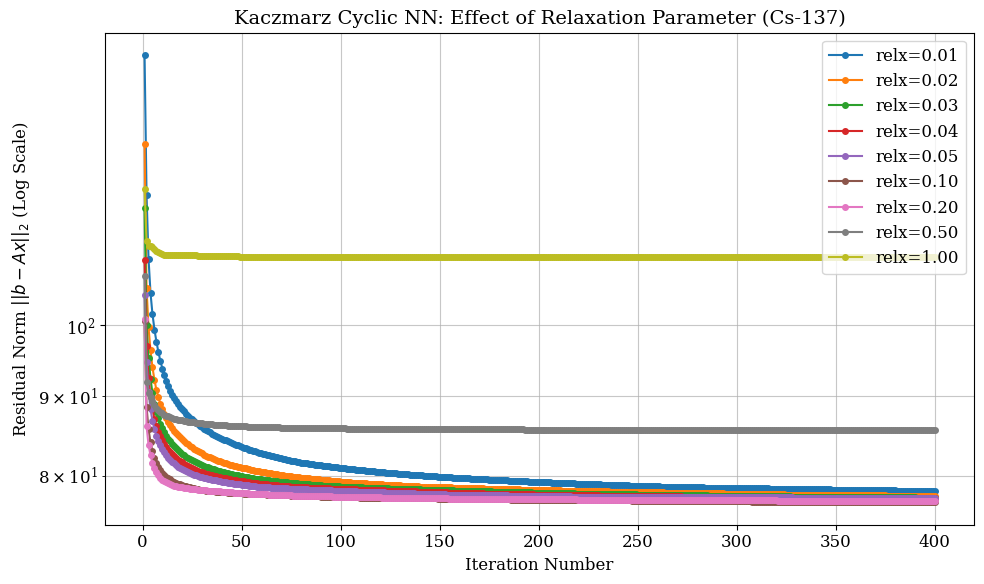

Cyclic Kaczmarz NN (CO, relx=0.01): 100%|██████████| 400/400 [00:41<00:00,  9.66it/s]


Cyclic NN (relx=0.01) Final Residual: 38.3288


Cyclic Kaczmarz NN (CO, relx=0.02): 100%|██████████| 400/400 [00:53<00:00,  7.52it/s]


Cyclic NN (relx=0.02) Final Residual: 38.1306


Cyclic Kaczmarz NN (CO, relx=0.03): 100%|██████████| 400/400 [00:49<00:00,  8.00it/s]


Cyclic NN (relx=0.03) Final Residual: 38.0848


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 400/400 [01:10<00:00,  5.67it/s]


Cyclic NN (relx=0.04) Final Residual: 38.0788


Cyclic Kaczmarz NN (CO, relx=0.05): 100%|██████████| 400/400 [01:05<00:00,  6.09it/s]


Cyclic NN (relx=0.05) Final Residual: 38.0678


Cyclic Kaczmarz NN (CO, relx=0.10): 100%|██████████| 400/400 [00:58<00:00,  6.81it/s]


Cyclic NN (relx=0.10) Final Residual: 38.1902


Cyclic Kaczmarz NN (CO, relx=0.20): 100%|██████████| 400/400 [00:54<00:00,  7.29it/s]


Cyclic NN (relx=0.20) Final Residual: 38.7626


Cyclic Kaczmarz NN (CO, relx=0.50): 100%|██████████| 400/400 [00:52<00:00,  7.66it/s]


Cyclic NN (relx=0.50) Final Residual: 41.2167


Cyclic Kaczmarz NN (CO, relx=1.00): 100%|██████████| 400/400 [00:57<00:00,  6.97it/s]


Cyclic NN (relx=1.00) Final Residual: 50.5709

Plotting Kaczmarz Cyclic NN: Effect of Relaxation Parameter (Cobalt-60)...


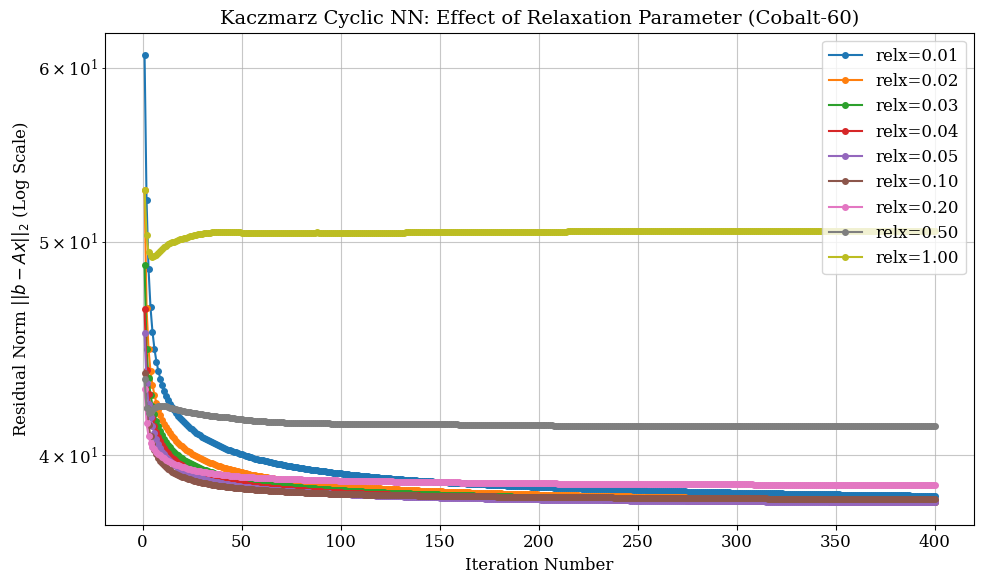


--- Testing Kaczmarz Upsweep NN with different relaxation parameters ---


Upsweep Kaczmarz NN (CS, relx=0.01): 100%|██████████| 400/400 [01:48<00:00,  3.70it/s]


Upsweep NN (relx=0.01) Final Residual: 77.8086


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 400/400 [02:02<00:00,  3.26it/s]


Upsweep NN (relx=0.02) Final Residual: 77.6544


Upsweep Kaczmarz NN (CS, relx=0.03): 100%|██████████| 400/400 [01:56<00:00,  3.43it/s]


Upsweep NN (relx=0.03) Final Residual: 77.8380


Upsweep Kaczmarz NN (CS, relx=0.04): 100%|██████████| 400/400 [01:55<00:00,  3.47it/s]


Upsweep NN (relx=0.04) Final Residual: 78.0790


Upsweep Kaczmarz NN (CS, relx=0.05): 100%|██████████| 400/400 [01:53<00:00,  3.52it/s]


Upsweep NN (relx=0.05) Final Residual: 78.3583


Upsweep Kaczmarz NN (CS, relx=0.10): 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


Upsweep NN (relx=0.10) Final Residual: 79.6451


Upsweep Kaczmarz NN (CS, relx=0.20): 100%|██████████| 400/400 [01:52<00:00,  3.54it/s]


Upsweep NN (relx=0.20) Final Residual: 82.1380


Upsweep Kaczmarz NN (CS, relx=0.50): 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


Upsweep NN (relx=0.50) Final Residual: 91.9144


Upsweep Kaczmarz NN (CS, relx=1.00): 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


Upsweep NN (relx=1.00) Final Residual: 98.0512

Plotting Kaczmarz Upsweep NN: Effect of Relaxation Parameter (Cs-137)...


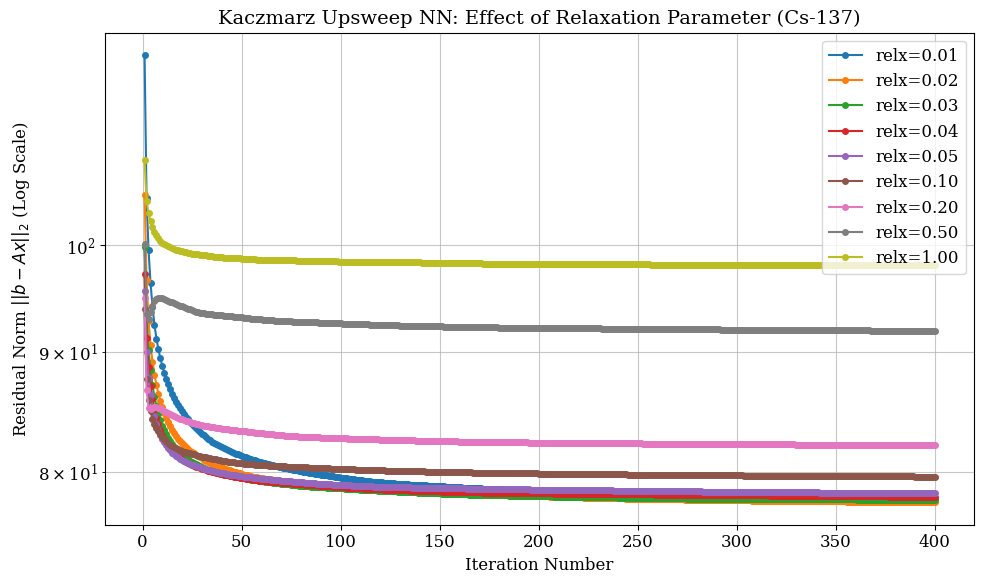

Upsweep Kaczmarz NN (CO, relx=0.01): 100%|██████████| 400/400 [01:49<00:00,  3.64it/s]


Upsweep NN (relx=0.01) Final Residual: 38.1325


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 400/400 [01:51<00:00,  3.60it/s]


Upsweep NN (relx=0.02) Final Residual: 38.1031


Upsweep Kaczmarz NN (CO, relx=0.03): 100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


Upsweep NN (relx=0.03) Final Residual: 38.1961


Upsweep Kaczmarz NN (CO, relx=0.04): 100%|██████████| 400/400 [02:29<00:00,  2.67it/s]


Upsweep NN (relx=0.04) Final Residual: 38.3367


Upsweep Kaczmarz NN (CO, relx=0.05): 100%|██████████| 400/400 [02:12<00:00,  3.02it/s]


Upsweep NN (relx=0.05) Final Residual: 38.5232


Upsweep Kaczmarz NN (CO, relx=0.10): 100%|██████████| 400/400 [01:55<00:00,  3.46it/s]


Upsweep NN (relx=0.10) Final Residual: 39.8264


Upsweep Kaczmarz NN (CO, relx=0.20): 100%|██████████| 400/400 [01:51<00:00,  3.60it/s]


Upsweep NN (relx=0.20) Final Residual: 42.4416


Upsweep Kaczmarz NN (CO, relx=0.50): 100%|██████████| 400/400 [01:25<00:00,  4.66it/s]


Upsweep NN (relx=0.50) Final Residual: 47.3367


Upsweep Kaczmarz NN (CO, relx=1.00): 100%|██████████| 400/400 [01:48<00:00,  3.69it/s]


Upsweep NN (relx=1.00) Final Residual: 49.0411

Plotting Kaczmarz Upsweep NN: Effect of Relaxation Parameter (Cobalt-60)...


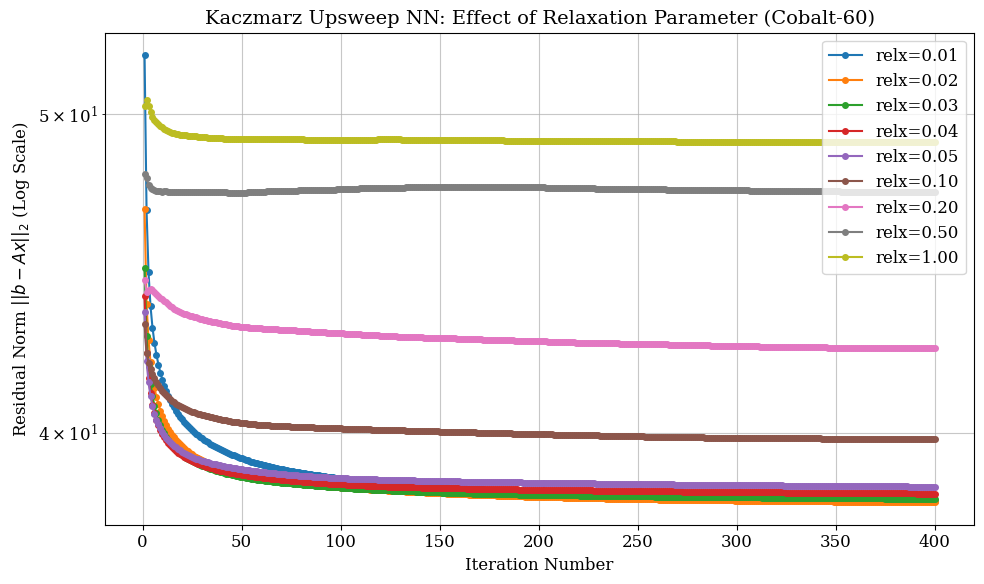


--- Testing Kaczmarz Randomized NN with different relaxation parameters ---


Randomized Kaczmarz NN (CS, relx=0.01): 100%|██████████| 400/400 [00:56<00:00,  7.03it/s]


Randomized NN (relx=0.01) Final Residual: 78.8173


Randomized Kaczmarz NN (CS, relx=0.02): 100%|██████████| 400/400 [01:00<00:00,  6.66it/s]


Randomized NN (relx=0.02) Final Residual: 77.0898


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 400/400 [01:03<00:00,  6.34it/s]


Randomized NN (relx=0.03) Final Residual: 80.2807


Randomized Kaczmarz NN (CS, relx=0.04): 100%|██████████| 400/400 [00:59<00:00,  6.68it/s]


Randomized NN (relx=0.04) Final Residual: 80.8668


Randomized Kaczmarz NN (CS, relx=0.05): 100%|██████████| 400/400 [01:03<00:00,  6.30it/s]


Randomized NN (relx=0.05) Final Residual: 77.2664


Randomized Kaczmarz NN (CS, relx=0.10): 100%|██████████| 400/400 [01:16<00:00,  5.25it/s]


Randomized NN (relx=0.10) Final Residual: 79.6035


Randomized Kaczmarz NN (CS, relx=0.20): 100%|██████████| 400/400 [01:23<00:00,  4.81it/s]


Randomized NN (relx=0.20) Final Residual: 81.6390


Randomized Kaczmarz NN (CS, relx=0.50): 100%|██████████| 400/400 [01:25<00:00,  4.68it/s]


Randomized NN (relx=0.50) Final Residual: 90.2141


Randomized Kaczmarz NN (CS, relx=1.00): 100%|██████████| 400/400 [01:01<00:00,  6.49it/s]


Randomized NN (relx=1.00) Final Residual: 129.0286

Plotting Kaczmarz Randomized NN: Effect of Relaxation Parameter (Cs-137)...


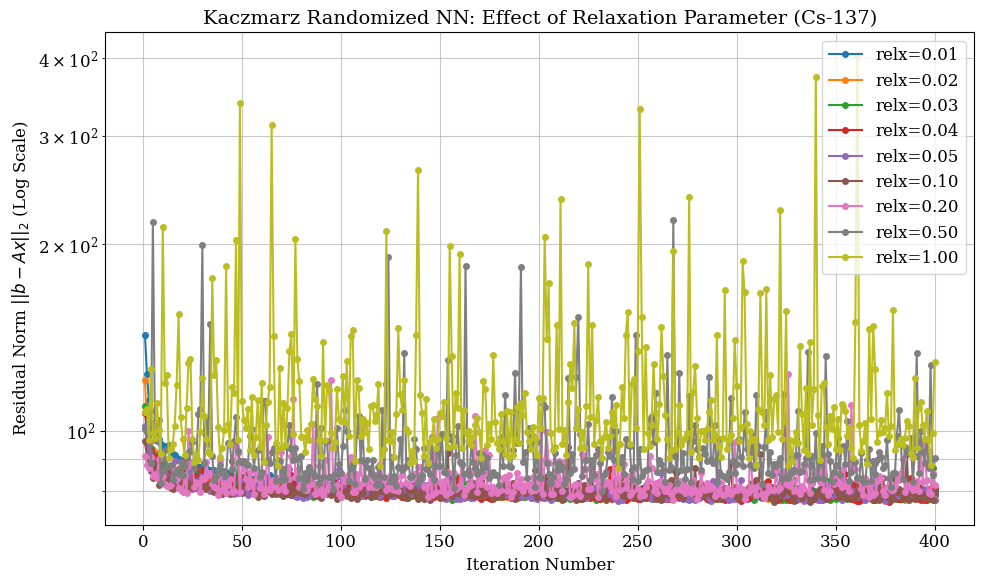

Randomized Kaczmarz NN (CO, relx=0.01): 100%|██████████| 400/400 [00:51<00:00,  7.81it/s]


Randomized NN (relx=0.01) Final Residual: 38.4321


Randomized Kaczmarz NN (CO, relx=0.02): 100%|██████████| 400/400 [00:43<00:00,  9.17it/s]


Randomized NN (relx=0.02) Final Residual: 38.2864


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 400/400 [00:54<00:00,  7.40it/s]


Randomized NN (relx=0.03) Final Residual: 38.2462


Randomized Kaczmarz NN (CO, relx=0.04): 100%|██████████| 400/400 [00:45<00:00,  8.87it/s]


Randomized NN (relx=0.04) Final Residual: 38.1836


Randomized Kaczmarz NN (CO, relx=0.05): 100%|██████████| 400/400 [00:53<00:00,  7.51it/s]


Randomized NN (relx=0.05) Final Residual: 38.5803


Randomized Kaczmarz NN (CO, relx=0.10): 100%|██████████| 400/400 [01:15<00:00,  5.27it/s]


Randomized NN (relx=0.10) Final Residual: 38.4970


Randomized Kaczmarz NN (CO, relx=0.20): 100%|██████████| 400/400 [01:00<00:00,  6.57it/s]


Randomized NN (relx=0.20) Final Residual: 39.5480


Randomized Kaczmarz NN (CO, relx=0.50): 100%|██████████| 400/400 [00:59<00:00,  6.68it/s]


Randomized NN (relx=0.50) Final Residual: 44.3217


Randomized Kaczmarz NN (CO, relx=1.00): 100%|██████████| 400/400 [01:01<00:00,  6.51it/s]


Randomized NN (relx=1.00) Final Residual: 43.6415

Plotting Kaczmarz Randomized NN: Effect of Relaxation Parameter (Cobalt-60)...


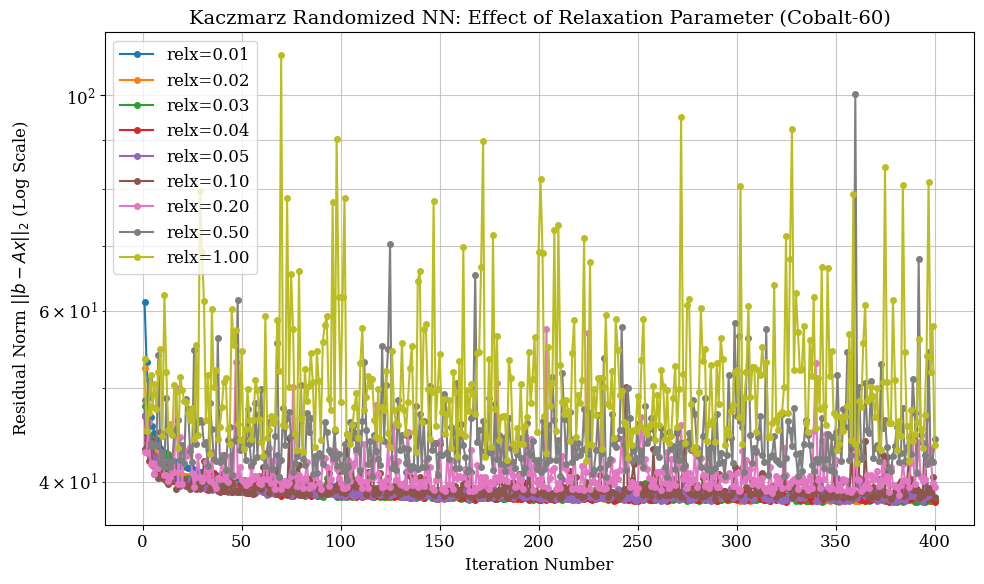


--- Relaxation parameter tests complete. ---


In [3]:
def kaczmarz_cyclic_nn(detectors, grid_points, b, A_matrix, n_iter=100, isotope_str="cs", relx=1.0):
    x, m, n, _, _ = _kaczmarz_base(detectors, grid_points, b, isotope=isotope_str)
    residuals_per_iteration = []
    for it in tqdm(range(n_iter), desc=f"Cyclic Kaczmarz NN ({isotope_str.upper()}, relx={relx:.2f})"):
        for i in range(m):
            A_i = A_matrix[i, :]
            A_i_norm_sq = np.sum(A_i**2)
            if A_i_norm_sq == 0: continue
            residual = b[i] - A_i @ x
            x += relx * (residual / A_i_norm_sq) * A_i # <-- Modified here
            x = np.maximum(0, x)
        residuals_per_iteration.append(calculate_system_residual(x, b, A_matrix))
    return x, np.array(residuals_per_iteration)

def kaczmarz_upsweep_nn(detectors, grid_points, b, A_matrix, n_iter=100, isotope_str="cs", relx=1.0):
    x, m, n, _, _ = _kaczmarz_base(detectors, grid_points, b, isotope=isotope_str)
    residuals_per_iteration = []
    for it in tqdm(range(n_iter), desc=f"Upsweep Kaczmarz NN ({isotope_str.upper()}, relx={relx:.2f})"):
        for i in range(m): # Forward sweep
            A_i = A_matrix[i, :]
            A_i_norm_sq = np.sum(A_i**2)
            if A_i_norm_sq == 0: continue
            residual = b[i] - A_i @ x
            x += relx * (residual / A_i_norm_sq) * A_i # <-- Modified here
            x = np.maximum(0, x)
        for i in range(m - 1, -1, -1): # Backward sweep
            A_i = A_matrix[i, :]
            A_i_norm_sq = np.sum(A_i**2)
            if A_i_norm_sq == 0: continue
            residual = b[i] - A_i @ x
            x += relx * (residual / A_i_norm_sq) * A_i # <-- Modified here
            x = np.maximum(0, x)
        residuals_per_iteration.append(calculate_system_residual(x, b, A_matrix))
    return x, np.array(residuals_per_iteration)

def kaczmarz_randomized_nn(detectors, grid_points, b, A_matrix, n_iter=100, isotope_str="cs", relx=1.0):
    x, m, n, _, _ = _kaczmarz_base(detectors, grid_points, b, isotope=isotope_str)
    detector_indices = list(range(m))
    residuals_per_iteration = []
    for it in tqdm(range(n_iter), desc=f"Randomized Kaczmarz NN ({isotope_str.upper()}, relx={relx:.2f})"):
        for _ in range(m): # A full pass means m updates
            i = random.choice(detector_indices)
            A_i = A_matrix[i, :]
            A_i_norm_sq = np.sum(A_i**2)
            if A_i_norm_sq == 0: continue
            residual = b[i] - A_i @ x
            x += relx * (residual / A_i_norm_sq) * A_i # <-- Modified here
            x = np.maximum(0, x)
        residuals_per_iteration.append(calculate_system_residual(x, b, A_matrix))
    return x, np.array(residuals_per_iteration)

# Relaxation parameters to test for each algorithm
test_relx_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1.0]
kaczmarz_n_iter = 400

# --- Test Script 1: Kaczmarz Cyclic NN with Relaxation ---
print("\n--- Testing Kaczmarz Cyclic NN with different relaxation parameters ---")
cyclic_nn_test_residuals = {}
for relx_val in test_relx_values:
    _, residuals = kaczmarz_cyclic_nn(detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs, 
                                       n_iter=kaczmarz_n_iter, isotope_str="cs", relx=relx_val)
    cyclic_nn_test_residuals[f'relx={relx_val:.2f}'] = residuals
    print(f"Cyclic NN (relx={relx_val:.2f}) Final Residual: {residuals[-1]:.4f}")

plot_residuals_over_iterations(cyclic_nn_test_residuals, kaczmarz_n_iter, 
                               title="Kaczmarz Cyclic NN: Effect of Relaxation Parameter (Cs-137)")

randomized_nn_test_residuals = {}
for relx_val in test_relx_values:
    _, residuals = kaczmarz_cyclic_nn(detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
                                        n_iter=kaczmarz_n_iter, isotope_str="co", relx=relx_val)
    cyclic_nn_test_residuals[f'relx={relx_val:.2f}'] = residuals
    print(f"Cyclic NN (relx={relx_val:.2f}) Final Residual: {residuals[-1]:.4f}")

plot_residuals_over_iterations(cyclic_nn_test_residuals, kaczmarz_n_iter, 
                               title="Kaczmarz Cyclic NN: Effect of Relaxation Parameter (Cobalt-60)")


# --- Test Script 2: Kaczmarz Upsweep NN with Relaxation ---
print("\n--- Testing Kaczmarz Upsweep NN with different relaxation parameters ---")
upsweep_nn_test_residuals = {}
for relx_val in test_relx_values:
    _, residuals = kaczmarz_upsweep_nn(detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs, 
                                        n_iter=kaczmarz_n_iter, isotope_str="cs", relx=relx_val)
    upsweep_nn_test_residuals[f'relx={relx_val:.2f}'] = residuals
    print(f"Upsweep NN (relx={relx_val:.2f}) Final Residual: {residuals[-1]:.4f}")

plot_residuals_over_iterations(upsweep_nn_test_residuals, kaczmarz_n_iter, 
                               title="Kaczmarz Upsweep NN: Effect of Relaxation Parameter (Cs-137)")

randomized_nn_test_residuals = {}
for relx_val in test_relx_values:
    _, residuals = kaczmarz_upsweep_nn(detectors, grid_points_for_reconstruction, b_co, A_matrix_co, 
                                        n_iter=kaczmarz_n_iter, isotope_str="co", relx=relx_val)
    upsweep_nn_test_residuals[f'relx={relx_val:.2f}'] = residuals
    print(f"Upsweep NN (relx={relx_val:.2f}) Final Residual: {residuals[-1]:.4f}")

plot_residuals_over_iterations(upsweep_nn_test_residuals, kaczmarz_n_iter, 
                               title="Kaczmarz Upsweep NN: Effect of Relaxation Parameter (Cobalt-60)")


# --- Test Script 3: Kaczmarz Randomized NN with Relaxation ---
print("\n--- Testing Kaczmarz Randomized NN with different relaxation parameters ---")
randomized_nn_test_residuals = {}
for relx_val in test_relx_values:
    _, residuals = kaczmarz_randomized_nn(detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs, 
                                          n_iter=kaczmarz_n_iter, isotope_str="cs", relx=relx_val)
    randomized_nn_test_residuals[f'relx={relx_val:.2f}'] = residuals
    print(f"Randomized NN (relx={relx_val:.2f}) Final Residual: {residuals[-1]:.4f}")

plot_residuals_over_iterations(randomized_nn_test_residuals, kaczmarz_n_iter, 
                               title="Kaczmarz Randomized NN: Effect of Relaxation Parameter (Cs-137)")


randomized_nn_test_residuals = {}
for relx_val in test_relx_values:
    _, residuals = kaczmarz_randomized_nn(detectors, grid_points_for_reconstruction, b_co, A_matrix_co, 
                                          n_iter=kaczmarz_n_iter, isotope_str="co", relx=relx_val)
    randomized_nn_test_residuals[f'relx={relx_val:.2f}'] = residuals
    print(f"Randomized NN (relx={relx_val:.2f}) Final Residual: {residuals[-1]:.4f}")

plot_residuals_over_iterations(randomized_nn_test_residuals, kaczmarz_n_iter, 
                               title="Kaczmarz Randomized NN: Effect of Relaxation Parameter (Cobalt-60)")

print("\n--- Relaxation parameter tests complete. ---")

In [4]:
# Different numbers of iterations to test
test_n_iter_values = [1, 10, 20, 50, 100, 200, 300]
fixed_relx = 0.02 # Using default relx to isolate num_iterations effect


# --- Test Script 1: Kaczmarz Cyclic NN with varying Iterations ---
print("\n--- Testing Kaczmarz Cyclic NN with different numbers of iterations ---")
cyclic_nn_iter_residuals = {}
for n_iter_val in test_n_iter_values:
    _, residuals = kaczmarz_cyclic_nn(detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs, 
                                       n_iter=n_iter_val, isotope_str="cs", relx=0.1)
    cyclic_nn_iter_residuals[f'Iter={n_iter_val}'] = residuals
    print(f"Cyclic NN (Iter={n_iter_val}) Final Residual: {residuals[-1]:.4f}")



# --- Test Script 2: Kaczmarz Upsweep NN with varying Iterations ---
print("\n--- Testing Kaczmarz Upsweep NN with different numbers of iterations ---")
upsweep_nn_iter_residuals = {}
for n_iter_val in test_n_iter_values:
    _, residuals = kaczmarz_upsweep_nn(detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs, 
                                        n_iter=n_iter_val, isotope_str="cs", relx=0.02)
    upsweep_nn_iter_residuals[f'Iter={n_iter_val}'] = residuals
    print(f"Upsweep NN (Iter={n_iter_val}) Final Residual: {residuals[-1]:.4f}")

# plot_residuals_over_iterations(upsweep_nn_iter_residuals, max(test_n_iter_values), 
#                                title=f"Kaczmarz Upsweep NN: Effect of Iterations (Cs-137, relx={fixed_relx})")


# --- Test Script 3: Kaczmarz Randomized NN with varying Iterations ---
print("\n--- Testing Kaczmarz Randomized NN with different numbers of iterations ---")
randomized_nn_iter_residuals = {}
for n_iter_val in test_n_iter_values:
    _, residuals = kaczmarz_randomized_nn(detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs, 
                                          n_iter=n_iter_val, isotope_str="cs", relx=0.03)
    randomized_nn_iter_residuals[f'Iter={n_iter_val}'] = residuals
    print(f"Randomized NN (Iter={n_iter_val}) Final Residual: {residuals[-1]:.4f}")

# plot_residuals_over_iterations(randomized_nn_iter_residuals, max(test_n_iter_values), 
#                                title=f"Kaczmarz Randomized NN: Effect of Iterations (Cs-137, relx={fixed_relx})")


print("\n--- ITERATION COUNT COMPLETE FOR CS NOW STARTING CO ---")
# --- Test Script 4: Kaczmarz Cyclic NN with varying Iterations for Cobalt (Co) ---
print("\n--- Testing Kaczmarz Cyclic NN with different numbers of iterations for Cobalt (Co) ---")
cyclic_nn_iter_residuals_co = {}
for n_iter_val in test_n_iter_values:
    _, residuals = kaczmarz_cyclic_nn(detectors, grid_points_for_reconstruction, b_co, A_matrix_co, 
                                       n_iter=n_iter_val, isotope_str="co", relx=0.04)
    cyclic_nn_iter_residuals_co[f'Iter={n_iter_val}'] = residuals
    print(f"Cyclic NN (Iter={n_iter_val}) Final Residual (Co): {residuals[-1]:.4f}")
# plot_residuals_over_iterations(cyclic_nn_iter_residuals_co, max(test_n_iter_values), 
#                                title=f"Kaczmarz Cyclic NN: Effect of Iterations (Cobalt-60, relx={fixed_relx})")

# --- Test Script 5: Kaczmarz Upsweep NN with varying Iterations for Cobalt (Co) ---
print("\n--- Testing Kaczmarz Upsweep NN with different numbers of iterations for Cobalt (Co) ---")
upsweep_nn_iter_residuals_co = {}
for n_iter_val in test_n_iter_values:
    _, residuals = kaczmarz_upsweep_nn(detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
                                        n_iter=n_iter_val, isotope_str="co", relx=0.02)
    upsweep_nn_iter_residuals_co[f'Iter={n_iter_val}'] = residuals
    print(f"Upsweep NN (Iter={n_iter_val}) Final Residual (Co): {residuals[-1]:.4f}")
# plot_residuals_over_iterations(upsweep_nn_iter_residuals_co, max(test_n_iter_values),
#                                  title=f"Kaczmarz Upsweep NN: Effect of Iterations (Cobalt-60, relx={fixed_relx})")

# --- Test Script 6: Kaczmarz Randomized NN with varying Iterations for Cobalt (Co) ---
print("\n--- Testing Kaczmarz Randomized NN with different numbers of iterations for Cobalt (Co) ---")
randomized_nn_iter_residuals_co = {}
for n_iter_val in test_n_iter_values:
    _, residuals = kaczmarz_randomized_nn(detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
                                          n_iter=n_iter_val, isotope_str="co", relx=0.03)
    randomized_nn_iter_residuals_co[f'Iter={n_iter_val}'] = residuals
    print(f"Randomized NN (Iter={n_iter_val}) Final Residual (Co): {residuals[-1]:.4f}")
# plot_residuals_over_iterations(randomized_nn_iter_residuals_co, max(test_n_iter_values),
#                                title=f"Kaczmarz Randomized NN: Effect of Iterations (Cobalt-60, relx={fixed_relx})")

print("\n--- Iteration count tests complete. ---")


--- Testing Kaczmarz Cyclic NN with different numbers of iterations ---


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


Cyclic NN (Iter=1) Final Residual: 100.6573


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


Cyclic NN (Iter=10) Final Residual: 80.3968


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Cyclic NN (Iter=20) Final Residual: 78.9281


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Cyclic NN (Iter=50) Final Residual: 77.9561


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Cyclic NN (Iter=100) Final Residual: 77.5325


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 200/200 [00:29<00:00,  6.68it/s]


Cyclic NN (Iter=200) Final Residual: 77.2392


Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]


Cyclic NN (Iter=300) Final Residual: 77.0454

--- Testing Kaczmarz Upsweep NN with different numbers of iterations ---


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Upsweep NN (Iter=1) Final Residual: 105.0381


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


Upsweep NN (Iter=10) Final Residual: 85.2643


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Upsweep NN (Iter=20) Final Residual: 82.2953


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


Upsweep NN (Iter=50) Final Residual: 79.8447


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


Upsweep NN (Iter=100) Final Residual: 78.8400


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 200/200 [00:56<00:00,  3.51it/s]


Upsweep NN (Iter=200) Final Residual: 78.1282


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 300/300 [01:27<00:00,  3.43it/s]


Upsweep NN (Iter=300) Final Residual: 77.8108

--- Testing Kaczmarz Randomized NN with different numbers of iterations ---


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Randomized NN (Iter=1) Final Residual: 113.6696


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


Randomized NN (Iter=10) Final Residual: 86.1380


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


Randomized NN (Iter=20) Final Residual: 84.7637


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Randomized NN (Iter=50) Final Residual: 79.9863


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Randomized NN (Iter=100) Final Residual: 79.0288


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 200/200 [00:30<00:00,  6.58it/s]


Randomized NN (Iter=200) Final Residual: 78.0881


Randomized Kaczmarz NN (CS, relx=0.03): 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]


Randomized NN (Iter=300) Final Residual: 80.0773

--- ITERATION COUNT COMPLETE FOR CS NOW STARTING CO ---

--- Testing Kaczmarz Cyclic NN with different numbers of iterations for Cobalt (Co) ---


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Cyclic NN (Iter=1) Final Residual (Co): 46.5946


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


Cyclic NN (Iter=10) Final Residual (Co): 40.4263


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 20/20 [00:03<00:00,  6.44it/s]


Cyclic NN (Iter=20) Final Residual (Co): 39.5715


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]


Cyclic NN (Iter=50) Final Residual (Co): 38.8115


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Cyclic NN (Iter=100) Final Residual (Co): 38.4642


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Cyclic NN (Iter=200) Final Residual (Co): 38.2235


Cyclic Kaczmarz NN (CO, relx=0.04): 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]


Cyclic NN (Iter=300) Final Residual (Co): 38.1250

--- Testing Kaczmarz Upsweep NN with different numbers of iterations for Cobalt (Co) ---


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Upsweep NN (Iter=1) Final Residual (Co): 46.7743


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Upsweep NN (Iter=10) Final Residual (Co): 40.4770


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Upsweep NN (Iter=20) Final Residual (Co): 39.6237


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Upsweep NN (Iter=50) Final Residual (Co): 38.8652


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


Upsweep NN (Iter=100) Final Residual (Co): 38.5011


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 200/200 [00:57<00:00,  3.50it/s]


Upsweep NN (Iter=200) Final Residual (Co): 38.2495


Upsweep Kaczmarz NN (CO, relx=0.02): 100%|██████████| 300/300 [01:25<00:00,  3.49it/s]


Upsweep NN (Iter=300) Final Residual (Co): 38.1516

--- Testing Kaczmarz Randomized NN with different numbers of iterations for Cobalt (Co) ---


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


Randomized NN (Iter=1) Final Residual (Co): 48.2172


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


Randomized NN (Iter=10) Final Residual (Co): 41.4493


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 20/20 [00:03<00:00,  6.21it/s]


Randomized NN (Iter=20) Final Residual (Co): 40.5215


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


Randomized NN (Iter=50) Final Residual (Co): 39.1089


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Randomized NN (Iter=100) Final Residual (Co): 38.8494


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 200/200 [00:30<00:00,  6.49it/s]


Randomized NN (Iter=200) Final Residual (Co): 38.4359


Randomized Kaczmarz NN (CO, relx=0.03): 100%|██████████| 300/300 [00:45<00:00,  6.62it/s]

Randomized NN (Iter=300) Final Residual (Co): 39.4848

--- Iteration count tests complete. ---


In [ ]:
import numpy as np
import open3d as o3d
from pyproj import Transformer
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import rcParams
from tqdm import tqdm
import random
import time
from itertools import product
import warnings

# --- Define Hyperparameter Ranges ---
n_iter_range = [100, 200, 400, 500]
relx_range = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
hyperparameter_combinations = list(product(relx_range, n_iter_range))

# --- Data and Grid Setup ---
b_cs = df_brno['cs_photo'].values.astype(np.float32)
b_co = df_brno['co_photo'].values.astype(np.float32)

buffer_distance = 50.0
det_min_x, det_max_x = detectors[:, 0].min(), detectors[:, 0].max()
det_min_y = detectors[:, 1].min()
det_max_y = detectors[:, 1].max()

grid_min_x, grid_max_x = det_min_x - buffer_distance, det_max_x + buffer_distance
grid_min_y, grid_max_y = det_min_y - buffer_distance, det_max_y + buffer_distance

grid_x, grid_y, _ = create_reconstruction_grid_extent(grid_min_x, grid_max_x, grid_min_y, grid_max_y, voxel_size=2.0)
xx_mesh, yy_mesh = np.meshgrid(grid_x, grid_y, indexing='ij')
Z_terrain_interpolated = griddata(original_terrain_points[:, :2], original_terrain_points[:, 2], 
                                  (xx_mesh, yy_mesh), method='nearest')
grid_points_for_reconstruction = np.stack([xx_mesh.ravel(), yy_mesh.ravel(), Z_terrain_interpolated.ravel()], axis=1).astype(np.float32)

_, _, _, emission_prob_cs, mu_L_cs = _kaczmarz_base(detectors, grid_points_for_reconstruction, b_cs, isotope="cs")
A_matrix_cs = _get_A_matrix(detectors, grid_points_for_reconstruction, emission_prob_cs, mu_L_cs)

_, _, _, emission_prob_co, mu_L_co = _kaczmarz_base(detectors, grid_points_for_reconstruction, b_co, isotope="co")
A_matrix_co = _get_A_matrix(detectors, grid_points_for_reconstruction, emission_prob_co, mu_L_co)

# --- Hyperparameter Tuning Loop ---
tuning_results = []
algorithms = {
    'Cyclic NN': kaczmarz_cyclic_nn,
    'Symmetric NN': kaczmarz_upsweep_nn,
    'Randomized NN': kaczmarz_randomized_nn
}
isotopes = {
    'Cs': (b_cs, A_matrix_cs),
    'Co': (b_co, A_matrix_co)
}

print("\n" + "="*50)
print("STARTING HYPERPARAMETER TUNING")
print("This may take some time...")
print("="*50)

total_runs = len(algorithms) * len(isotopes) * len(hyperparameter_combinations)
pbar = tqdm(total=total_runs, desc="Hyperparameter Tuning Progress")

for algo_name, algo_func in algorithms.items():
    for isotope_name, (b_data, A_matrix) in isotopes.items():
        for relx, n_iter in hyperparameter_combinations:
            start_time = time.time()
            _, final_residual = algo_func(detectors, grid_points_for_reconstruction, b_data, A_matrix, n_iter=n_iter, isotope_str=isotope_name, relx=relx)
            end_time = time.time()
            time_taken = end_time - start_time
            
            tuning_results.append({
                'Algorithm': algo_name,
                'Isotope': isotope_name,
                'Relx': relx,
                'Iterations': n_iter,
                'Final Residual': final_residual,
                'Time (s)': time_taken
            })
            pbar.update(1)
pbar.close()

# --- Summary of Best Hyperparameters ---
print("\n" + "="*50)
print("HYPERPARAMETER TUNING COMPLETE")
print("Best hyperparameters for each algorithm (Lowest Final Residual):")
print("="*50)



Created 2D grid extent: X=(np.float32(646762.5), np.float32(647143.75)), Y=(np.float32(5462112.5), np.float32(5462775.5))

STARTING HYPERPARAMETER TUNING
This may take some time...


Hyperparameter Tuning Progress: 100%|██████████| 144/144 [5:02:51<00:00, 126.19s/it]


HYPERPARAMETER TUNING COMPLETE
Best hyperparameters for each algorithm (Lowest Final Residual):


ValueError: operands could not be broadcast together with shapes (200,) (100,) 

In [5]:
tuning_results[0]

NameError: name 'tuning_results' is not defined

    Algorithm Isotope  Relx  Iterations                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Cyclic Kaczmarz NN (CS, relx=0.10): 100%|██████████| 500/500 [02:35<00:00,  3.22it/s]



Creating side-by-side plot for Cyclic NN (Cs) ...


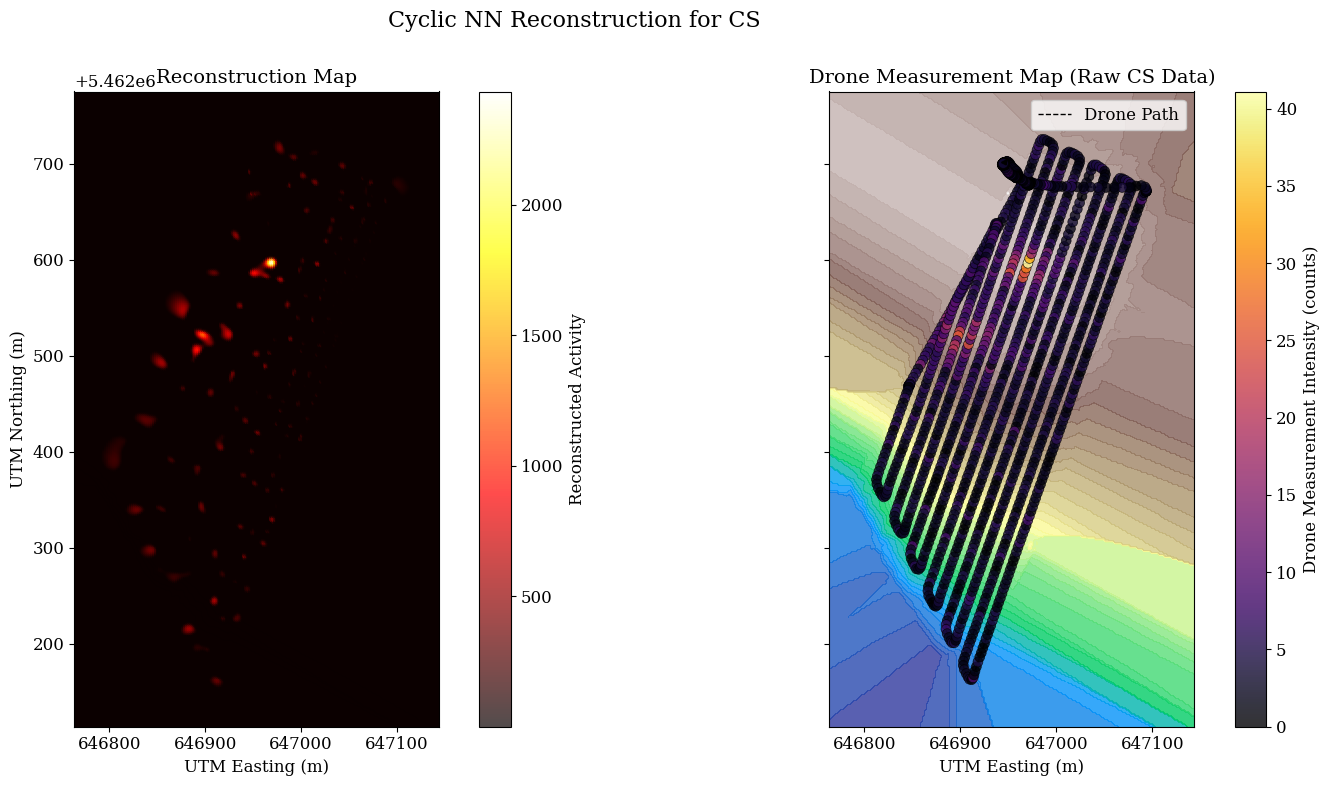


Reconstructing with optimal parameters for Cyclic NN (Co): relx=0.05, n_iter=500


Cyclic Kaczmarz NN (CO, relx=0.05): 100%|██████████| 500/500 [04:23<00:00,  1.90it/s]



Creating side-by-side plot for Cyclic NN (Co) ...


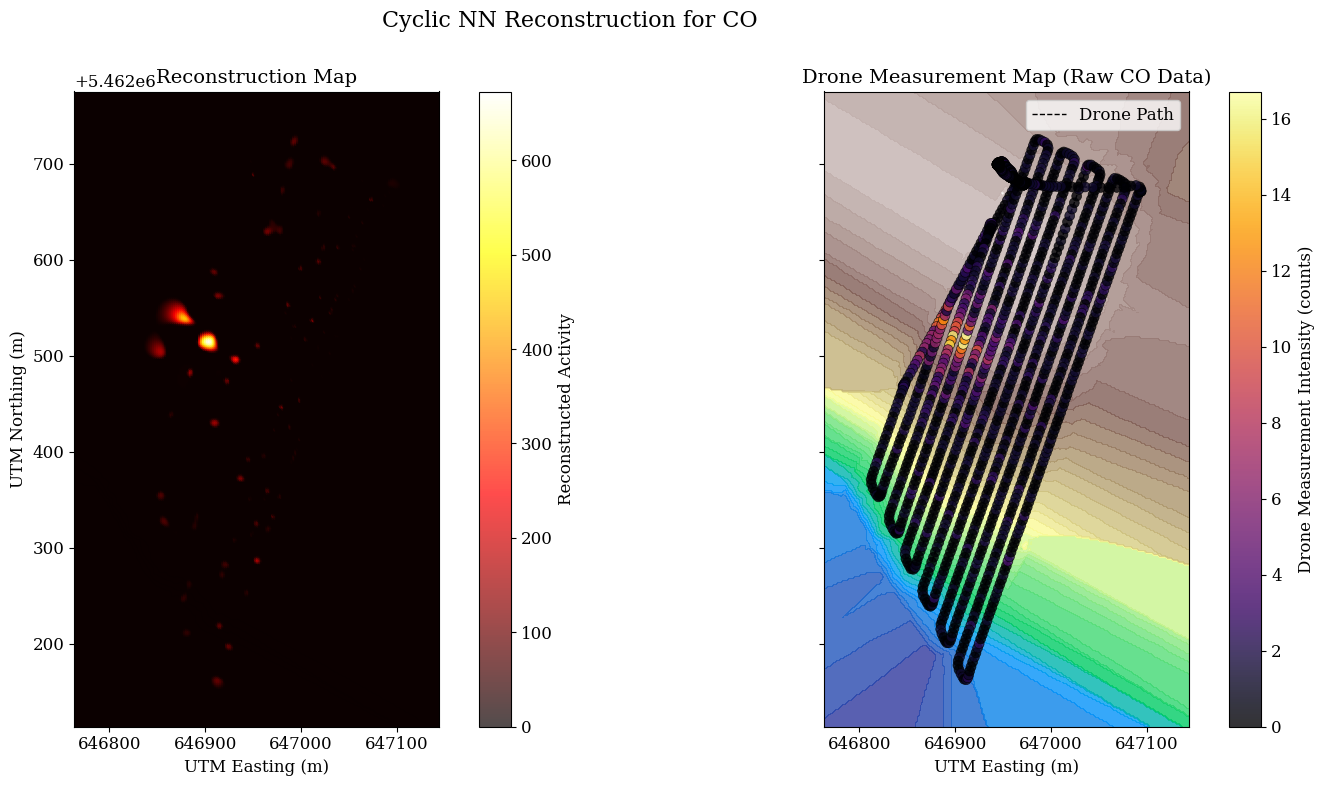


Reconstructing with optimal parameters for Symmetric NN (Cs): relx=0.02, n_iter=500


Upsweep Kaczmarz NN (CS, relx=0.02): 100%|██████████| 500/500 [09:16<00:00,  1.11s/it]



Creating side-by-side plot for Symmetric NN (Cs) ...


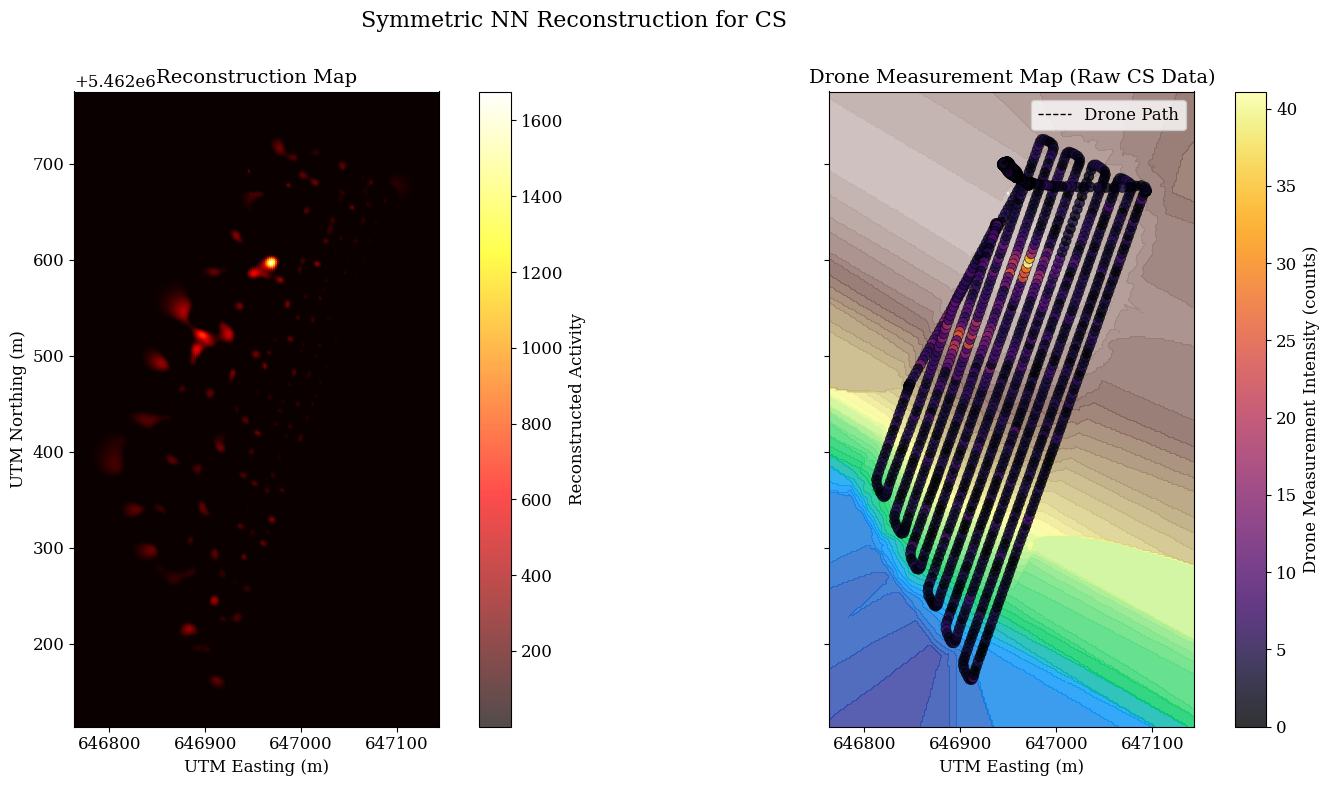


Reconstructing with optimal parameters for Symmetric NN (Co): relx=0.01, n_iter=500


Upsweep Kaczmarz NN (CO, relx=0.01): 100%|██████████| 500/500 [09:30<00:00,  1.14s/it]



Creating side-by-side plot for Symmetric NN (Co) ...


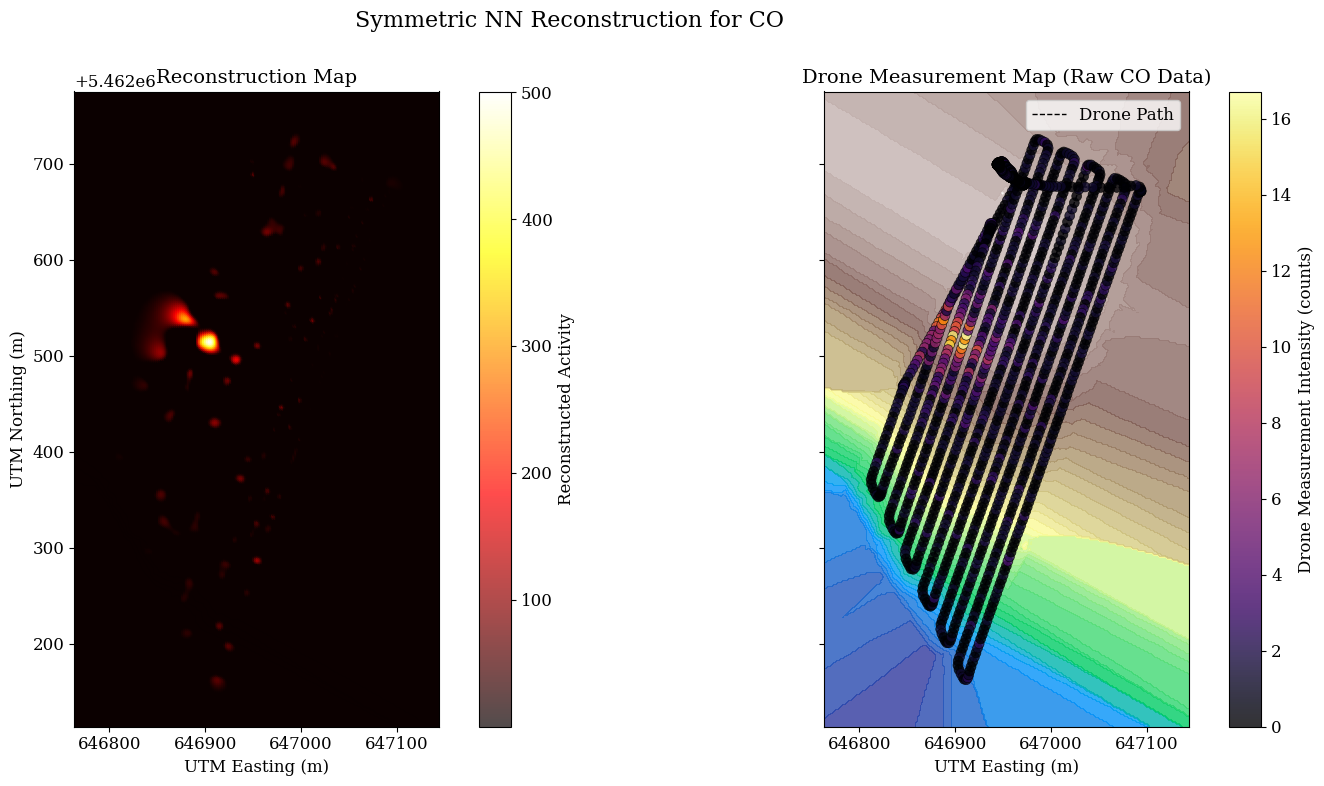


Reconstructing with optimal parameters for Randomized NN (Cs): relx=0.1, n_iter=500


Randomized Kaczmarz NN (CS, relx=0.10): 100%|██████████| 500/500 [04:18<00:00,  1.93it/s]



Creating side-by-side plot for Randomized NN (Cs) ...


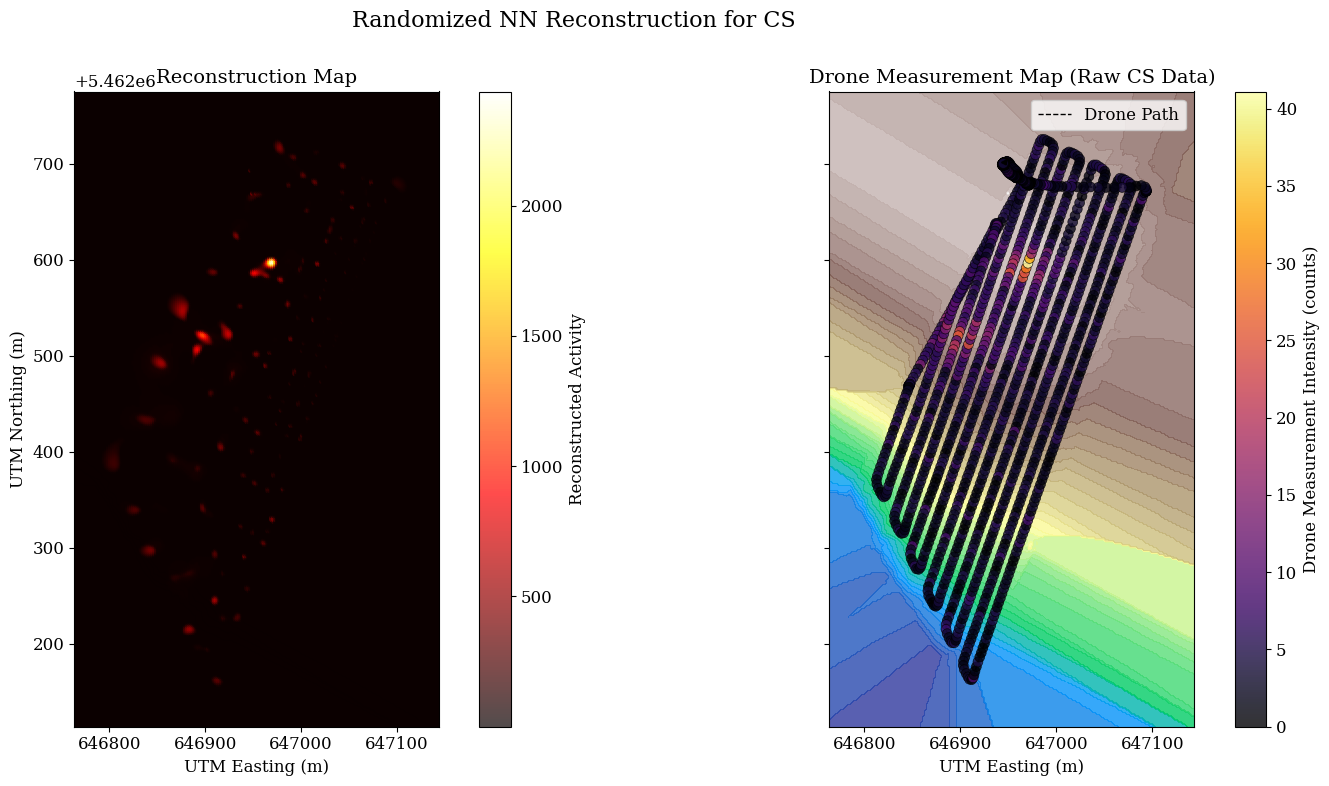


Reconstructing with optimal parameters for Randomized NN (Co): relx=0.02, n_iter=500


Randomized Kaczmarz NN (CO, relx=0.02): 100%|██████████| 500/500 [02:36<00:00,  3.19it/s]



Creating side-by-side plot for Randomized NN (Co) ...


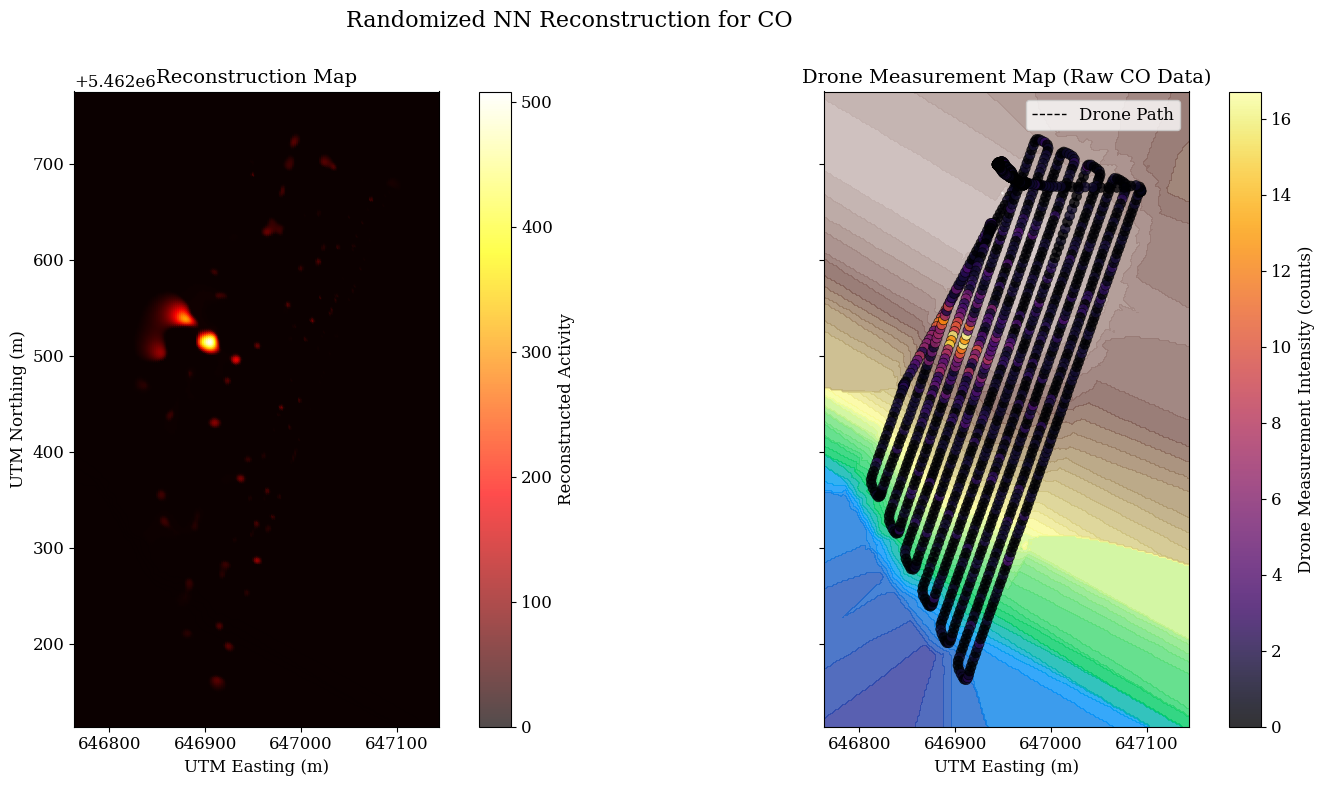


--- All optimal reconstructions have been plotted. ---


In [19]:
best_params_per_algo_isotope = {}
for algo_name in algorithms.keys():
    for isotope_name in isotopes.keys():
        best_run = min(
            [r for r in tuning_results if r['Algorithm'] == algo_name and r['Isotope'] == isotope_name],
            key=lambda x: np.min(x['Final Residual'])
        )
        best_params_per_algo_isotope[(algo_name, isotope_name)] = best_run

summary_table = []
for (algo_name, isotope_name), best_run in best_params_per_algo_isotope.items():
    summary_table.append(best_run)

df_summary = pd.DataFrame(summary_table)
print(df_summary.to_string(index=False))

# --- Plotting the Best Results ---
print("\n" + "="*50)
print("PLOTTING OPTIMAL RESULTS")
print("="*50)

for (algo_name, isotope_name), best_run in best_params_per_algo_isotope.items():
    relx_opt = best_run['Relx']
    n_iter_opt = best_run['Iterations']
    
    b_data, A_matrix = isotopes[isotope_name]
    algo_func = algorithms[algo_name]
    
    print(f"\nReconstructing with optimal parameters for {algo_name} ({isotope_name}): relx={relx_opt}, n_iter={n_iter_opt}")
    x_recon_best, _ = algo_func(detectors, grid_points_for_reconstruction, b_data, A_matrix, n_iter=n_iter_opt, isotope_str=isotope_name, relx=relx_opt)
    
    plot_reconstruction_and_measurements_side_by_side(x_recon_best, xx_mesh, yy_mesh, Z_terrain_interpolated, 
                                                     grid_points_for_reconstruction, detectors, b_data, 
                                                     algo_name, isotope_name)


print("\n--- All optimal reconstructions have been plotted. ---")


--- Calculating Singular Values... ---
Computed 1813 singular values for Cesium-137 matrix.
Computed 1813 singular values for Cobalt-60 matrix.

--- Plotting Singular Values... ---


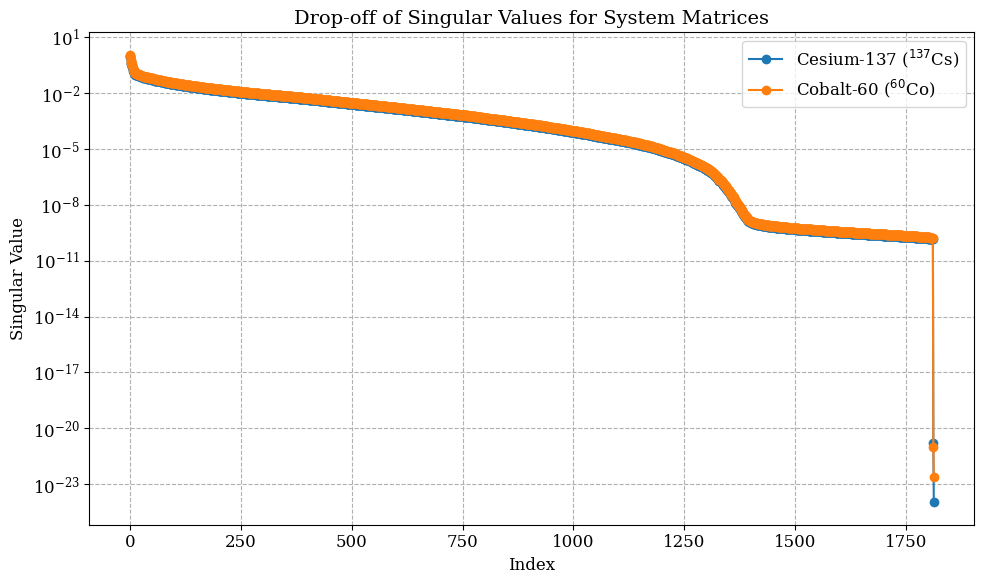

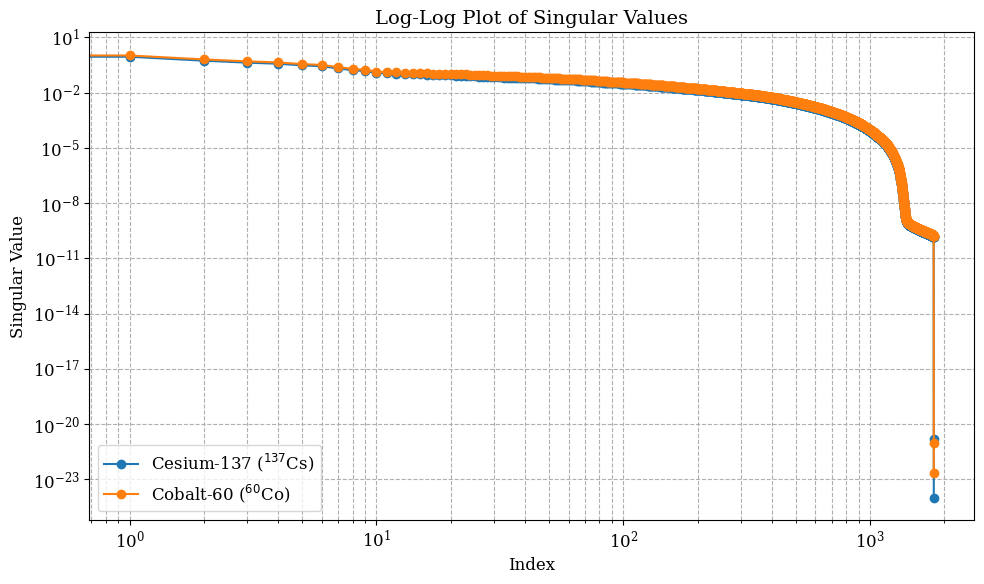

In [20]:
# Calculating Singular Values
print("\n--- Calculating Singular Values... ---")
sv_cs = np.linalg.svd(A_matrix_cs, compute_uv=False)
sv_co = np.linalg.svd(A_matrix_co, compute_uv=False)
print(f"Computed {len(sv_cs)} singular values for Cesium-137 matrix.")
print(f"Computed {len(sv_co)} singular values for Cobalt-60 matrix.")

# Plotting the drop of singular values
print("\n--- Plotting Singular Values... ---")
plt.figure(figsize=(10, 6))
plt.plot(sv_cs, 'o-', label=r'Cesium-137 ($^{137}$Cs)')
plt.plot(sv_co, 'o-', label=r'Cobalt-60 ($^{60}$Co)')
plt.yscale('log')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Drop-off of Singular Values for System Matrices')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.tight_layout()
plt.show()

# Plotting on a log-log scale for clearer visualization of the drop-off
plt.figure(figsize=(10, 6))
plt.loglog(sv_cs, 'o-', label=r'Cesium-137 ($^{137}$Cs)')
plt.loglog(sv_co, 'o-', label=r'Cobalt-60 ($^{60}$Co)')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Log-Log Plot of Singular Values')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.tight_layout()
plt.show()

In [21]:
from numpy.linalg import matrix_rank, svd

# Compute rank
rank_cs = matrix_rank(A_matrix_cs)
rank_co = matrix_rank(A_matrix_co)
print(f"Rank of A_matrix_cs: {rank_cs}")
print(f"Rank of A_matrix_co: {rank_co}")

# Compute null space (using SVD)
def null_space(A, rtol=1e-5):
    u, s, vh = svd(A, full_matrices=True)
    tol = rtol * s[0]
    null_mask = (s <= tol)
    null_space = vh[null_mask].T
    return null_space

null_cs = null_space(A_matrix_cs)
null_co = null_space(A_matrix_co)
print(f"Null space of A_matrix_cs has shape: {null_cs.shape}")
print(f"Null space of A_matrix_co has shape: {null_co.shape}")

Rank of A_matrix_cs: 308
Rank of A_matrix_co: 308


MemoryError: Unable to allocate 30.0 GiB for an array with shape (63412, 63412) and data type float64

# New

In [6]:
import numpy as np
from tqdm import tqdm
import random

def kaczmarz_randomized_tuned(detectors, grid_points, b, A_matrix, n_iter=100, omega=1.0, isotope_str="cs", with_replacement=True):
    """
    Randomized Kaczmarz with relaxation parameter omega, probability-weighted row selection,
    and option for with/without replacement.
    """
    x, m, n, _, _ = _kaczmarz_base(detectors, grid_points, b, isotope=isotope_str)
    residuals_per_iteration = []

    # Compute row norm squared and probabilities
    row_norms_sq = np.sum(A_matrix**2, axis=1)
    if np.sum(row_norms_sq) == 0:
        p = np.ones(m) / m
    else:
        p = row_norms_sq / np.sum(row_norms_sq)

    detector_indices = list(range(m))

    for _ in tqdm(range(n_iter), desc=f"Randomized Kaczmarz ω={omega}"):
        if with_replacement:
            # Pick rows with replacement, weighted by row norms
            for _ in range(m):
                i = np.random.choice(detector_indices, replace=True, p=p)
                A_i = A_matrix[i, :]
                Ai_norm_sq = row_norms_sq[i]
                if Ai_norm_sq == 0: continue
                residual = b[i] - A_i @ x
                x += omega * (residual / Ai_norm_sq) * A_i.flatten()
                x = np.maximum(0, x)  # Apply non-negativity constraint
        else:
            # Without replacement: shuffle once per iteration
            shuffled_indices = detector_indices.copy()
            random.shuffle(shuffled_indices)
            for i in shuffled_indices:
                A_i = A_matrix[i, :]
                Ai_norm_sq = row_norms_sq[i]
                if Ai_norm_sq == 0: continue
                residual = b[i] - A_i @ x
                x += omega * (residual / Ai_norm_sq) * A_i.flatten()
                x = np.maximum(0, x)  # Apply non-negativity constraint

        residuals_per_iteration.append(calculate_system_residual(x, b, A_matrix))

    return x, np.array(residuals_per_iteration)


def tune_randomized_kaczmarz(detectors, grid_points, b, A_matrix, omega_list, n_iter_list, isotope_str="cs", with_replacement=True):
    """
    Grid search over omega and n_iter to find best combination for randomized Kaczmarz.
    """
    best_residual = np.inf
    best_omega = None
    best_n_iter = None
    best_x = None

    for omega in omega_list:
        for n_iter in n_iter_list:
            x, _ = kaczmarz_randomized_tuned(detectors, grid_points, b, A_matrix,
                                             n_iter=n_iter, omega=omega,
                                             isotope_str=isotope_str,
                                             with_replacement=with_replacement)
            res = calculate_system_residual(x, b, A_matrix)
            if res < best_residual:
                best_residual = res
                best_omega = omega
                best_n_iter = n_iter
                best_x = x.copy()

    print(f"Best omega = {best_omega}, best n_iter = {best_n_iter}, residual = {best_residual:.6f}")
    return best_x, best_omega, best_n_iter, best_residual


# -----------------------------
# Example usage
# -----------------------------
omega_candidates = np.linspace(0.01, 2, 15)  # Relaxation parameters
n_iter_candidates = [50, 100, 200, 400]       # Number of full cycles

best_x, best_omega, best_n_iter, best_residual = tune_randomized_kaczmarz(
    detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs,
    omega_candidates, n_iter_candidates, isotope_str="cs", with_replacement=True
)

# Run final randomized Kaczmarz with best parameters
final_solution, residuals = kaczmarz_randomized_tuned(
    detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs,
    n_iter=best_n_iter, omega=best_omega, isotope_str="cs", with_replacement=True
)


Randomized Kaczmarz ω=2.0: 100%|██████████| 400/400 [05:39<00:00,  1.18it/s]


Best omega = 0.2942857142857143, best n_iter = 400, residual = 79.669228


Randomized Kaczmarz ω=0.2942857142857143: 100%|██████████| 400/400 [05:31<00:00,  1.21it/s]



Creating side-by-side plot for Tuned Kaczmarz (Cs, ω=0.29, n_iter=400) (cs) ...


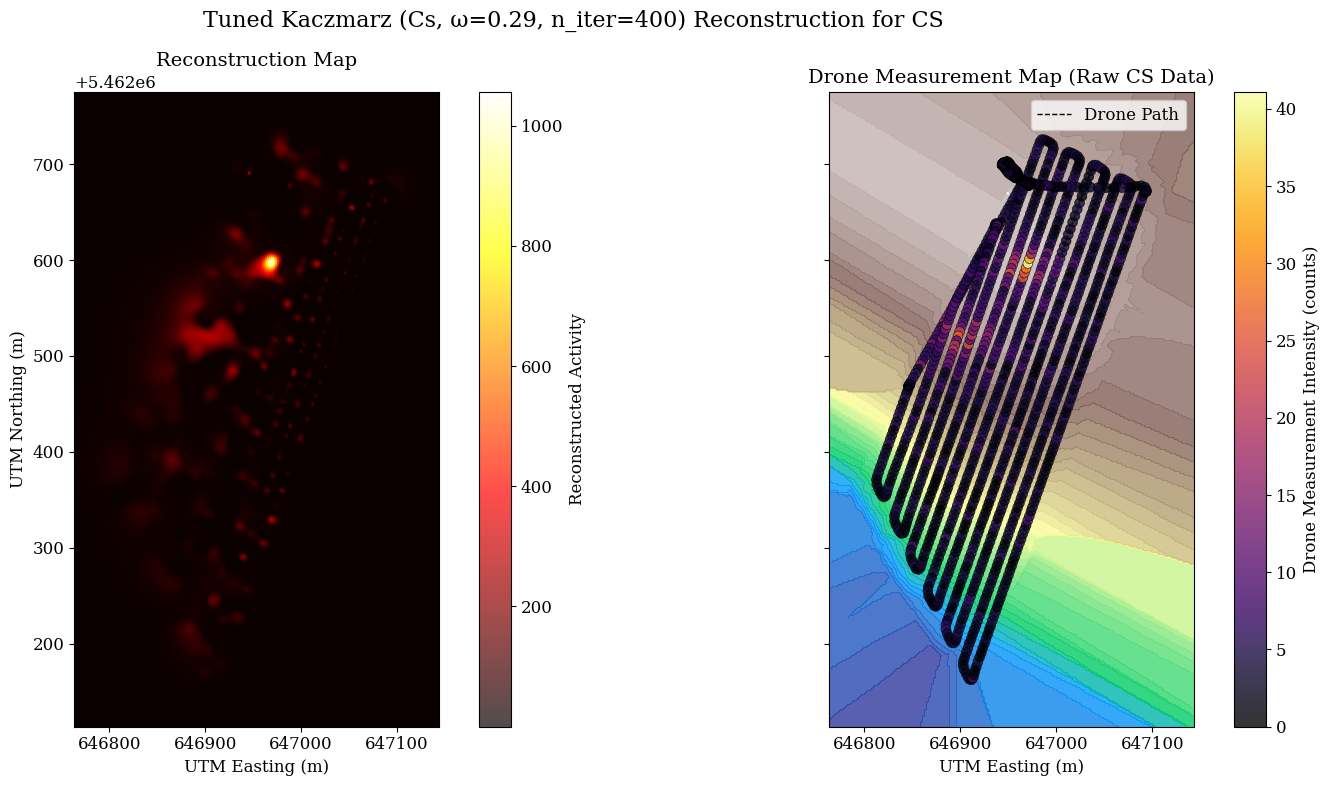

In [7]:
# Plot the results of the best Kaczmarz run
plot_reconstruction_and_measurements_side_by_side(
    final_solution,
    xx_mesh,
    yy_mesh,
    Z_terrain_interpolated,
    grid_points_for_reconstruction,
    detectors,
    b_cs,
    f"Tuned Kaczmarz (Cs, ω={best_omega:.2f}, n_iter={best_n_iter})",
    "cs"
)

In [8]:
best_x_no_replace, best_omega_no_replace, best_n_iter_no_replace, best_residual_no_replace = tune_randomized_kaczmarz(
    detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs,
    omega_candidates, n_iter_candidates, isotope_str="cs", with_replacement=False
)

# Run final randomized Kaczmarz with best parameters
final_solution_no_replace, residuals_no_replace = kaczmarz_randomized_tuned(
    detectors, grid_points_for_reconstruction, b_cs, A_matrix_cs,
    n_iter=best_n_iter_no_replace, omega=best_omega_no_replace, isotope_str="cs", with_replacement=False
)

Randomized Kaczmarz ω=2.0: 100%|██████████| 400/400 [08:18<00:00,  1.25s/it]


Best omega = 0.01, best n_iter = 400, residual = 78.465950


Randomized Kaczmarz ω=0.01: 100%|██████████| 400/400 [06:00<00:00,  1.11it/s]


In [3]:
# Plot the results of the best Kaczmarz run
plot_reconstruction_and_measurements_side_by_side(
    final_solution_no_replace,
    xx_mesh,
    yy_mesh,
    Z_terrain_interpolated,
    grid_points_for_reconstruction,
    detectors,
    b_cs,
    f"Tuned Kaczmarz (Cs, ω={best_omega:.2f}, n_iter={best_n_iter})",
    "cs"
)

NameError: name 'plot_reconstruction_and_measurements_side_by_side' is not defined

In [2]:
plot_reconstruction_and_measurements_side_by_side2(
    final_solution_no_replace,
    xx_mesh,
    yy_mesh,
    Z_terrain_interpolated,
    grid_points_for_reconstruction,
    detectors,
    b_cs,
    f"Tuned Kaczmarz (Cs, ω={best_omega:.2f}, n_iter={best_n_iter})",
    "cs"
)

NameError: name 'plot_reconstruction_and_measurements_side_by_side2' is not defined

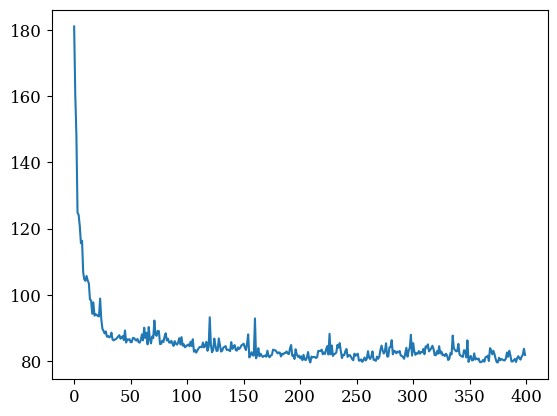

In [10]:
plt.plot(residuals)

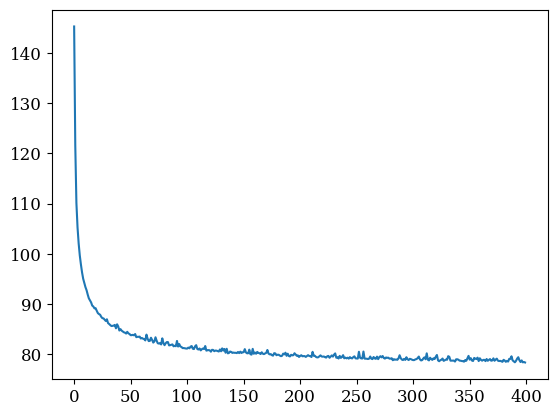

In [11]:
plt.plot(residuals_no_replace)

## Doing the same for Co

Randomized Kaczmarz ω=2.0: 100%|██████████| 400/400 [09:41<00:00,  1.45s/it]


Best omega = 0.2942857142857143, best n_iter = 400, residual = 40.212933


Randomized Kaczmarz ω=0.2942857142857143: 100%|██████████| 400/400 [07:22<00:00,  1.11s/it]



Creating side-by-side plot for Tuned Kaczmarz (Co, ω=0.29, n_iter=400) (co) ...


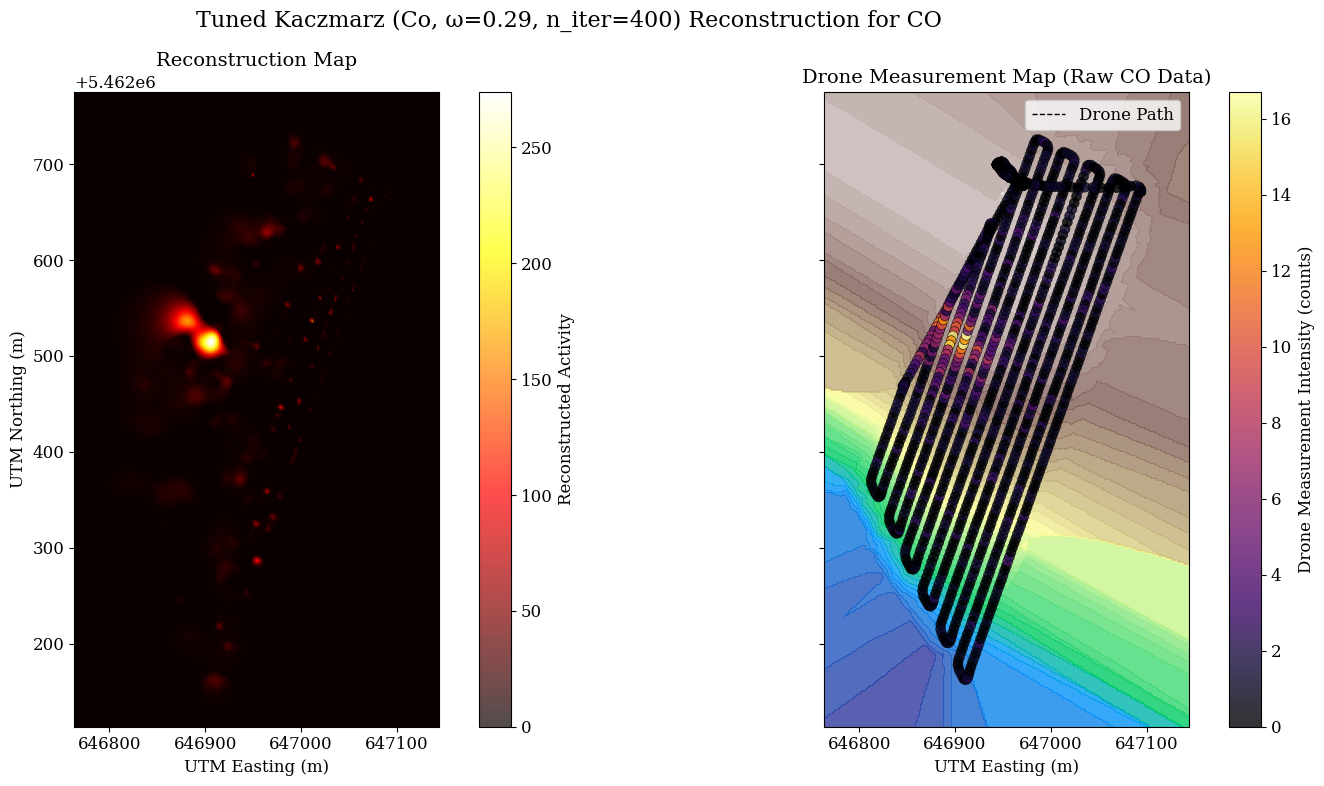

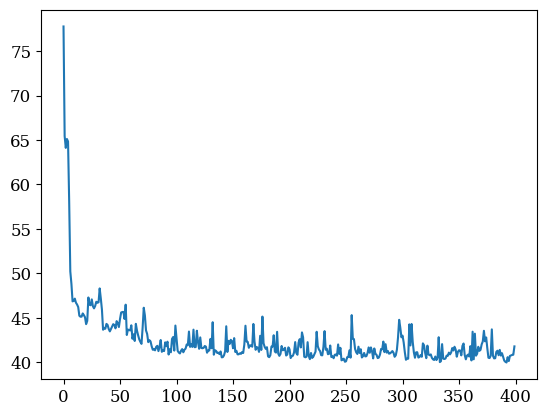

In [12]:
best_x_co, best_omega_co, best_n_iter_co, best_residual_co = tune_randomized_kaczmarz(
    detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
    omega_candidates, n_iter_candidates, isotope_str="co", with_replacement=True
)

# Run final randomized Kaczmarz with best parameters
final_solution_co, residuals_co = kaczmarz_randomized_tuned(
    detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
    n_iter=best_n_iter_co, omega=best_omega_co, isotope_str="co", with_replacement=True
)
plot_reconstruction_and_measurements_side_by_side(
    final_solution_co,
    xx_mesh,
    yy_mesh,
    Z_terrain_interpolated,
    grid_points_for_reconstruction,
    detectors,
    b_co,
    f"Tuned Kaczmarz (Co, ω={best_omega_co:.2f}, n_iter={best_n_iter_co})",
    "co"
)
plt.plot(residuals_co)

Randomized Kaczmarz ω=2.0: 100%|██████████| 400/400 [04:25<00:00,  1.50it/s]


Best omega = 0.01, best n_iter = 400, residual = 38.284954


Randomized Kaczmarz ω=0.01: 100%|██████████| 400/400 [03:55<00:00,  1.70it/s]



Creating side-by-side plot for Tuned Kaczmarz (Co, ω=0.01, n_iter=400) (co) ...


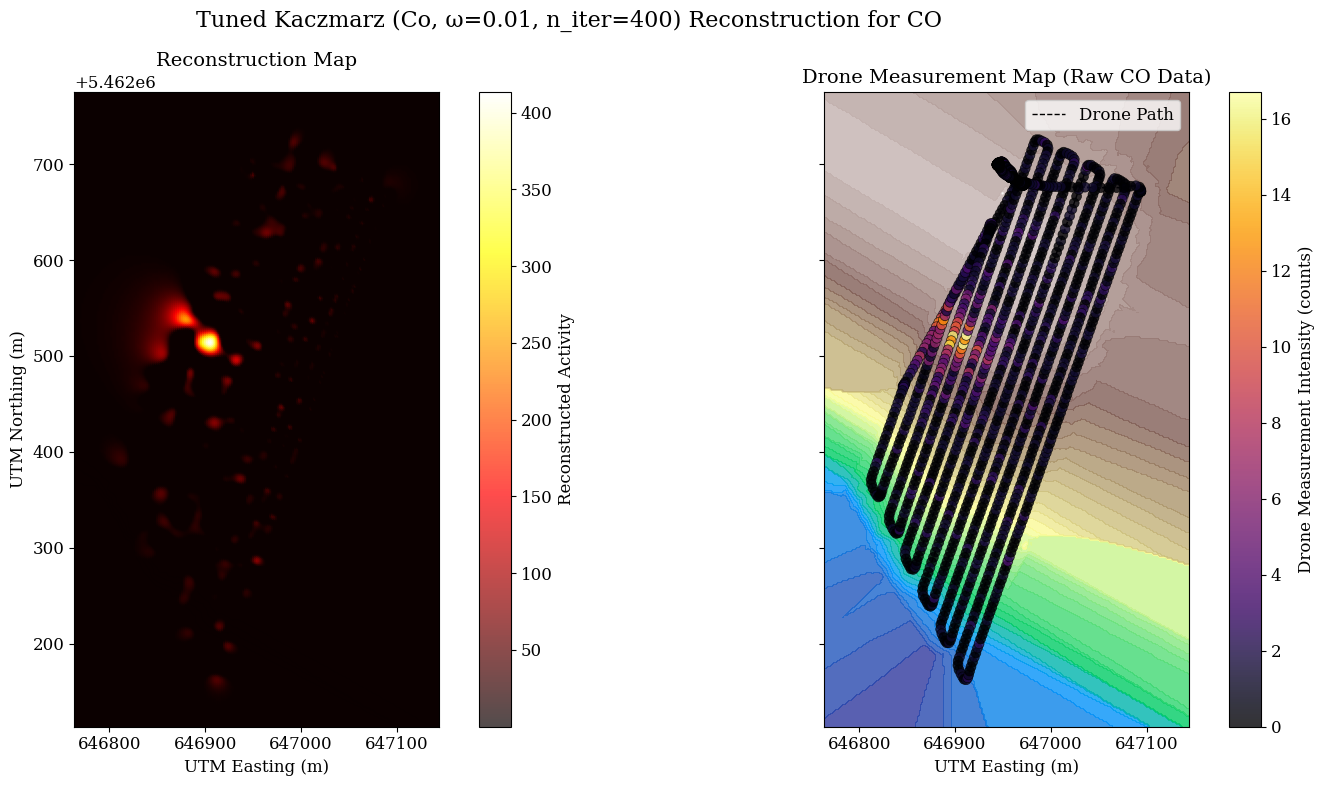

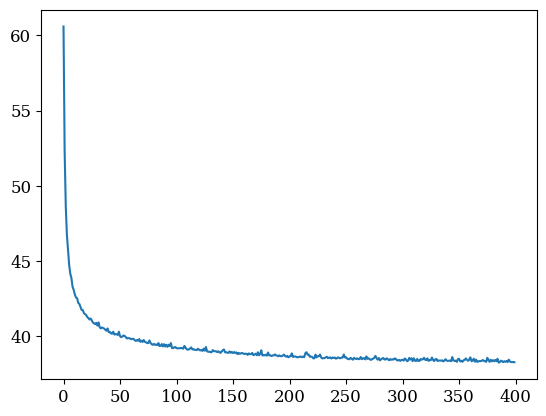

In [13]:
best_x_no_replace_co, best_omega_no_replace_co, best_n_iter_no_replace_co, best_residual_no_replace_co = tune_randomized_kaczmarz(
    detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
    omega_candidates, n_iter_candidates, isotope_str="co", with_replacement=False
)

# Run final randomized Kaczmarz with best parameters
final_solution_no_replace_co, residuals_no_replace_co = kaczmarz_randomized_tuned(
    detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
    n_iter=best_n_iter_no_replace_co, omega=best_omega_no_replace_co, isotope_str="co", with_replacement=False
)
plot_reconstruction_and_measurements_side_by_side(
    final_solution_no_replace_co,
    xx_mesh,
    yy_mesh,
    Z_terrain_interpolated,
    grid_points_for_reconstruction,
    detectors,
    b_co,
    f"Tuned Kaczmarz (Co, ω={best_omega_no_replace_co:.2f}, n_iter={best_n_iter_no_replace_co})",
    "co"
)
plt.plot(residuals_no_replace_co)

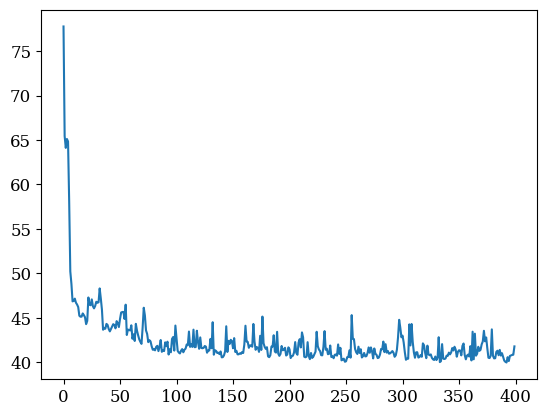

In [14]:
plt.plot(residuals_co)

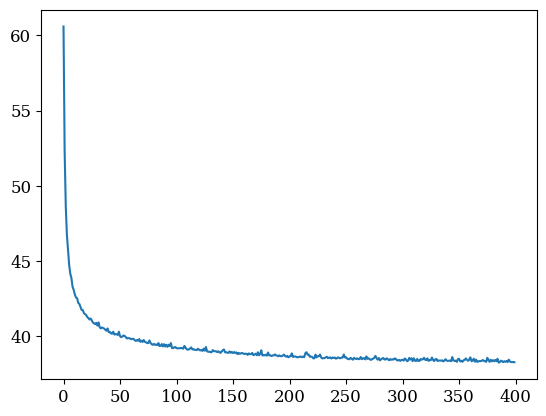

In [15]:
plt.plot(residuals_no_replace_co)

In [6]:
def kaczmarz_randomized_tuned(detectors, grid_points, b, A_matrix, n_iter=100, omega=1.0, isotope_str="cs", with_replacement=True):
    """
    Randomized Kaczmarz with relaxation parameter omega, probability-weighted row selection,
    and option for with/without replacement.
    """
    x, m, n, _, _ = _kaczmarz_base(detectors, grid_points, b, isotope=isotope_str)
    residuals_per_iteration = []

    # Compute row norm squared and probabilities
    row_norms_sq = np.sum(A_matrix**2, axis=1)
    if np.sum(row_norms_sq) == 0:
        p = np.ones(m) / m
    else:
        p = row_norms_sq / np.sum(row_norms_sq)

    detector_indices = list(range(m))

    for _ in tqdm(range(n_iter), desc=f"Randomized Kaczmarz ω={omega}"):
        if with_replacement:
            # Pick rows with replacement, weighted by row norms
            for _ in range(m):
                i = np.random.choice(detector_indices, replace=True, p=p)
                A_i = A_matrix[i, :]
                Ai_norm_sq = row_norms_sq[i]
                if Ai_norm_sq == 0: continue
                residual = b[i] - A_i @ x
                x += omega * (residual / Ai_norm_sq) * A_i.flatten()
                x = np.maximum(0, x)  # Apply non-negativity constraint
        else:
            # Without replacement: shuffle once per iteration
            shuffled_indices = detector_indices.copy()
            random.shuffle(shuffled_indices)
            for i in shuffled_indices:
                A_i = A_matrix[i, :]
                Ai_norm_sq = row_norms_sq[i]
                if Ai_norm_sq == 0: continue
                residual = b[i] - A_i @ x
                x += omega * (residual / Ai_norm_sq) * A_i.flatten()
                x = np.maximum(0, x)  # Apply non-negativity constraint

        residuals_per_iteration.append(calculate_system_residual(x, b, A_matrix))

    return x, np.array(residuals_per_iteration)


In [ ]:
final_solution_no_replace_co, residuals_no_replace_co = kaczmarz_randomized_tuned(
    detectors, grid_points_for_reconstruction, b_co, A_matrix_co,
    n_iter=400, omega=0.01, isotope_str="co", with_replacement=False
)


Randomized Kaczmarz ω=0.01: 100%|██████████| 400/400 [01:58<00:00,  3.37it/s]


NameError: name 'best_omega_no_replace_co' is not defined


Creating side-by-side plot for Tuned Kaczmarz (Co, ω=0.01, n_iter=400) (co) ...


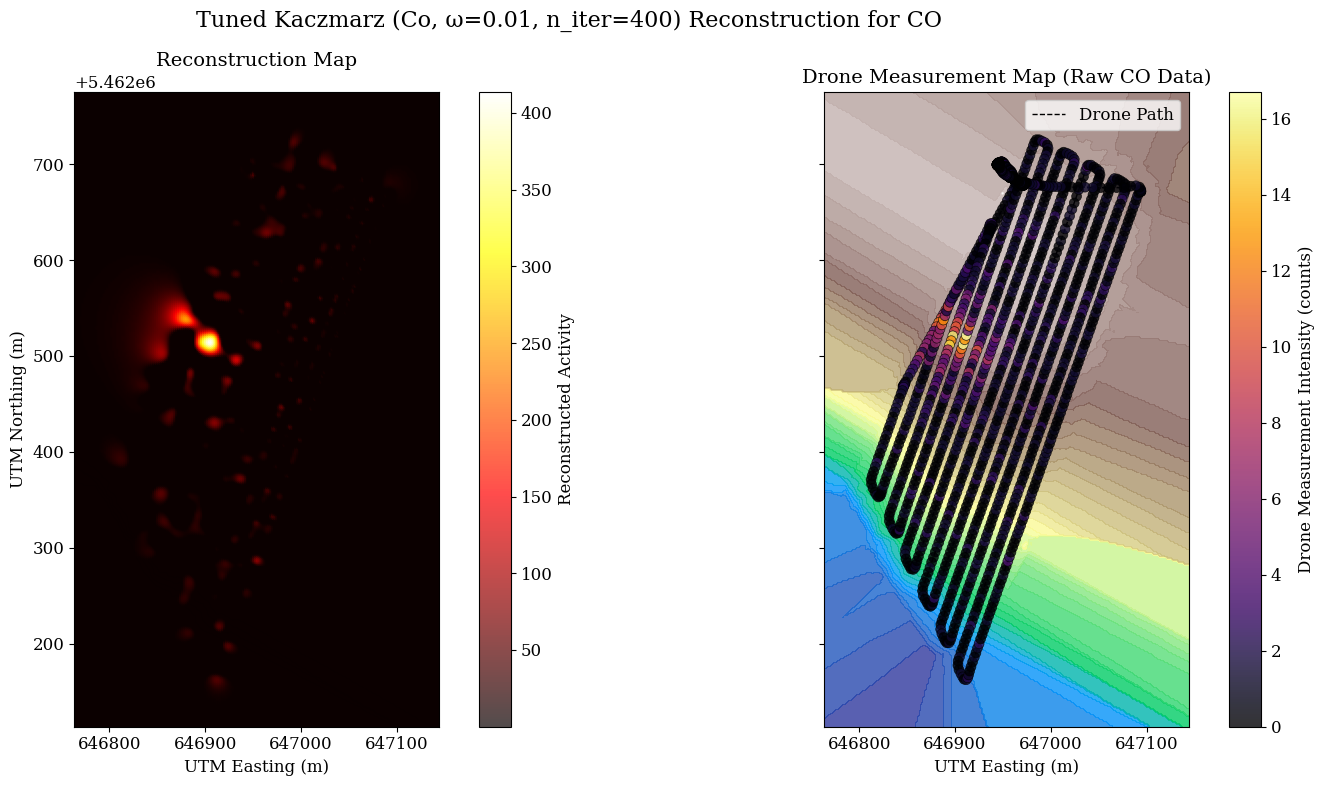

In [8]:
plot_reconstruction_and_measurements_side_by_side(
    final_solution_no_replace_co,
    xx_mesh,
    yy_mesh,
    Z_terrain_interpolated,
    grid_points_for_reconstruction,
    detectors,
    b_co,
    f"Tuned Kaczmarz (Co, ω={0.01:.2f}, n_iter={400})",
    "co"
)

In [9]:
def plot_reconstruction_and_measurements_side_by_side2(x_recon, xx_mesh, yy_mesh, Z_terrain,
                                                     grid_points_for_reconstruction, detectors,
                                                     b_values, algo_name, isotope_str,
                                                     threshold_percentage=0.0):
    print(f"\nCreating side-by-side plot for {algo_name} ({isotope_str}) ...")

    # Create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    fig.suptitle(f"{algo_name} Reconstruction for {isotope_str.upper()}", fontsize=16)

    # --- Left Subplot: Reconstruction Map ---
    # Plot the terrain elevation as a background
    contour_levels = 50
    ax1.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)

    scatter_x = grid_points_for_reconstruction[:, 0]
    scatter_y = grid_points_for_reconstruction[:, 1]
    reconstruction_plot = ax1.scatter(scatter_x, scatter_y, c=x_recon,
                                     cmap='hot', s=50, alpha=0.7, edgecolors='none')
    fig.colorbar(reconstruction_plot, ax=ax1, label="Reconstructed Activity", pad=0.05)

    # Find and plot the highest reconstruction point
    max_recon_idx = np.argmax(x_recon)
    max_recon_loc = grid_points_for_reconstruction[max_recon_idx]
    ax1.scatter(max_recon_loc[0], max_recon_loc[1], s=50, marker='o', c='yellow', edgecolors='black', zorder=5)
    ax1.annotate(f"Peak\n({max_recon_loc[0]:.0f}, {max_recon_loc[1]:.0f})",
                 (max_recon_loc[0], max_recon_loc[1]),
                 textcoords="offset points", xytext=(-20,-20), ha='center', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.7))

    ax1.set_title("Reconstruction Map")
    ax1.set_xlabel("UTM Easting (m)")
    ax1.set_ylabel("UTM Northing (m)")
    ax1.set_aspect('equal', adjustable='box')

    # --- Right Subplot: Drone Measurements ---
    # Plot the terrain elevation as a background
    #ax2.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)

    # Plot the drone flight path
    ax2.plot(detectors[:, 0], detectors[:, 1], color='black', linestyle='--', linewidth=1, zorder=2, label='Drone Path')

    # Plot the "true hotspot" measurements from the drone
    scatter_drone = ax2.scatter(detectors[:, 0], detectors[:, 1],
                               c=b_values, cmap='inferno', s=50, alpha=0.8,
                               edgecolors='black', linewidth=0.5, zorder=3)

    # Find and plot the highest drone measurement point
    max_b_idx = np.argmax(b_values)
    max_b_loc = detectors[max_b_idx]
    ax2.scatter(max_b_loc[0], max_b_loc[1], s=50, marker='o', c='yellow', edgecolors='black', zorder=5)
    ax2.annotate(f"Peak\n({max_b_loc[0]:.0f}, {max_b_loc[1]:.0f})",
                 (max_b_loc[0], max_b_loc[1]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.7))

    # Add a colorbar for the drone measurements
    fig.colorbar(scatter_drone, ax=ax2, label="Drone Measurement Intensity (counts)", pad=0.05)

    # Add arrow to indicate start of path
    if len(detectors) > 1:
        ax2.arrow(detectors[0, 0], detectors[0, 1],
                  detectors[1, 0] - detectors[0, 0], detectors[1, 1] - detectors[0, 1],
                  head_width=5, head_length=5, fc='black', ec='black', zorder=4)

    ax2.set_title(f"Drone Measurement Map (Raw {isotope_str.upper()} Data)")
    ax2.set_xlabel("UTM Easting (m)")
    ax2.set_aspect('equal', adjustable='box')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # --- Print the comparison ---
    print("\n--- Peak Location Comparison ---")
    print(f"Reconstructed Peak Location (UTM): ({max_recon_loc[0]:.2f}, {max_recon_loc[1]:.2f})")
    print(f"Measured Peak Location (UTM): ({max_b_loc[0]:.2f}, {max_b_loc[1]:.2f})")
    distance = np.linalg.norm(max_recon_loc[:2] - max_b_loc[:2])
    print(f"Distance between peaks: {distance:.2f} meters")



Creating side-by-side plot for Tuned Kaczmarz (Co, ω=0.01, n_iter=400) (co) ...


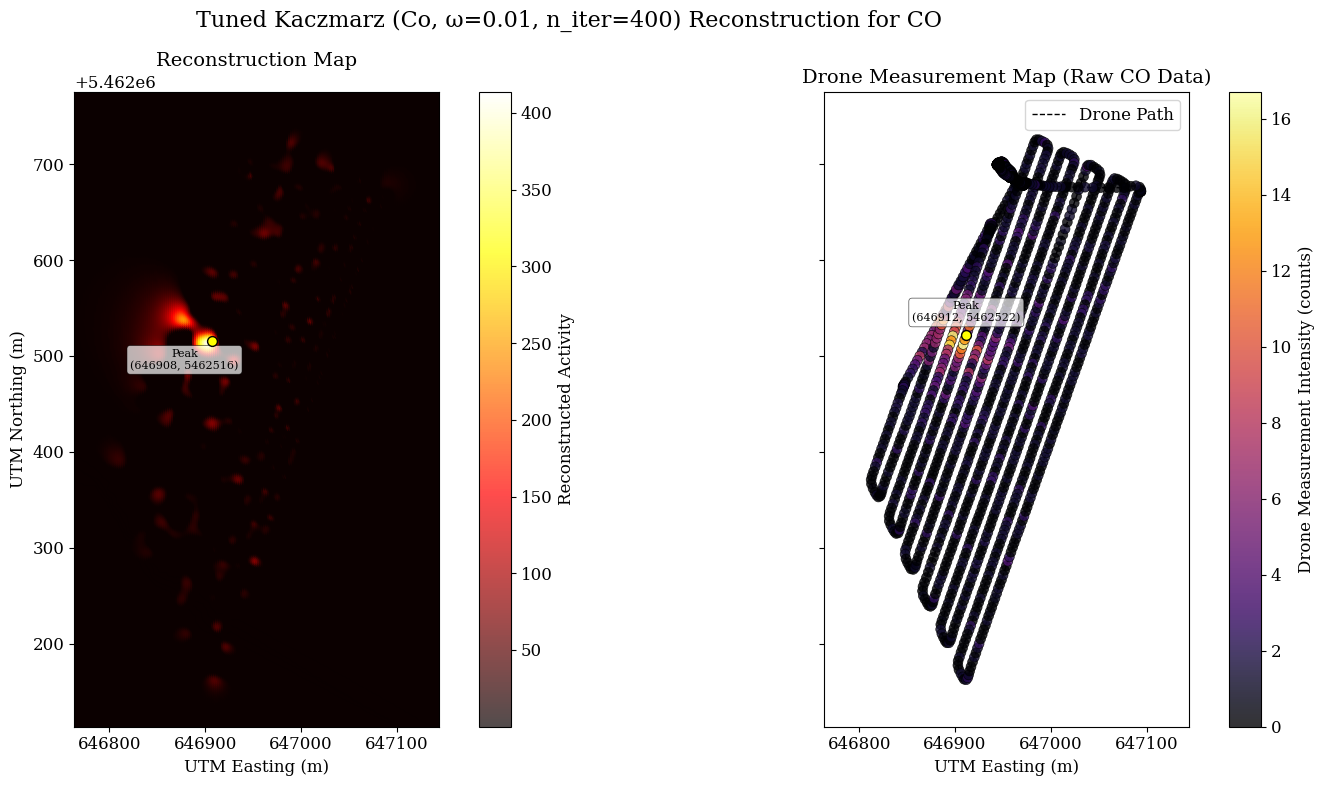


--- Peak Location Comparison ---
Reconstructed Peak Location (UTM): (646907.50, 5462515.50)
Measured Peak Location (UTM): (646911.75, 5462521.50)
Distance between peaks: 7.35 meters


In [10]:
plot_reconstruction_and_measurements_side_by_side2(
    final_solution_no_replace_co,
    xx_mesh,
    yy_mesh,
    Z_terrain_interpolated,
    grid_points_for_reconstruction,
    detectors,
    b_co,
    f"Tuned Kaczmarz (Co, ω={0.01:.2f}, n_iter={400})",
    "co"
)

In [11]:
residuals_no_replace_co

array([60.08512 , 52.256813, 48.85564 , 46.74285 , 45.596684, 44.68355 ,
       44.1233  , 43.709534, 43.332493, 43.015537, 42.779133, 42.557632,
       42.51074 , 42.264366, 42.059128, 42.037853, 41.87425 , 41.67665 ,
       41.618366, 41.48534 , 41.385353, 41.276176, 41.254498, 41.17571 ,
       41.092434, 40.984547, 40.93862 , 40.869713, 40.901054, 40.991642,
       40.736046, 40.68958 , 40.621723, 40.59293 , 40.545887, 40.6342  ,
       40.531822, 40.453976, 40.398247, 40.339607, 40.291164, 40.267616,
       40.24303 , 40.220688, 40.14854 , 40.1491  , 40.175236, 40.20238 ,
       40.052933, 40.156925, 40.035725, 40.030525, 39.92762 , 39.98829 ,
       39.92685 , 39.859257, 40.126255, 39.908096, 39.84435 , 39.873524,
       39.961857, 39.78442 , 39.83952 , 39.744038, 39.74937 , 39.717674,
       39.65667 , 39.845444, 39.80631 , 39.651222, 39.645473, 39.595898,
       39.724052, 39.561165, 39.587597, 39.554432, 39.464966, 39.472115,
       39.511345, 39.680626, 39.521397, 39.431473, 